# **Лабораторная работа 1:** препроцессинг данных

Импортируем необходимые библиотеки:

In [2]:
import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as s
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns

## **Загрузка датасетов**

In [15]:
reg_data = pd.read_csv('advertising.csv')
reg_data

TV  radio  newspaper  sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]

In [24]:
class_data = pd.read_csv('heart.csv')
class_data

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

## **Первичный статистический анализ датасетов**

Зададим необходимые дополнительные функции для анализа:

In [18]:
def statistics_measures(data):  # Вычисление статистических мер
    stats = {}
    for column in data.columns:
        col_data = data[column]

        # Меры центральной тенденции
        mean = col_data.mean()
        median = col_data.median()
        mode_val = col_data.mode()[0]

        # Меры разброса
        variance = col_data.var()
        std_dev = col_data.std()
        min_val = col_data.min()
        max_val = col_data.max()
        iqr = col_data.quantile(0.75) - col_data.quantile(0.25)

        # Параметры формы распределений
        skewness = s.skew(col_data)  # асимметрия
        kurt = s.kurtosis(col_data)  # эксцесс

        stats[column] = {
            'Выборочное среднее': mean,
            'Медиана': median,
            'Мода': mode_val,
            'Дисперсия': variance,
            'СКО': std_dev,
            'Min-value': min_val,
            'Max-value': max_val,
            'IQR': iqr,
            'Асимметрия': skewness,
            'Эксцесс': kurt
        }
    return pd.DataFrame(stats)

def hist_ecdf_kde(data):  # Построение графиков
    for column in data.columns:
        fig, axs = plt.subplots(1, 3, figsize=(16, 5))

        # Гистограмма
        sns.histplot(data[column], kde=False, ax=axs[0], color='darkorchid', bins=35, alpha=0.5)
        axs[0].set_title(f'Гистограмма {column}')
        axs[0].set_xlabel(column)
        axs[0].set_ylabel('Частота')

        # ECDF
        ecdf = ECDF(data[column])
        axs[1].plot(ecdf.x, ecdf.y, linestyle='-', color='navy', linewidth=1.5)
        axs[1].set_title(f'ECDF {column}')
        axs[1].set_xlabel(column)
        axs[1].set_ylabel('ECDF')

        # KDE
        sns.kdeplot(data[column], ax=axs[2], fill=True, color='salmon', alpha=0.6)
        axs[2].set_title(f'KDE {column}')
        axs[2].set_xlabel(column)
        axs[2].set_ylabel('Плотность')

        plt.tight_layout()
        plt.show()

def pairplot(data, title):  # Построение pairplot
    pairplot = sns.pairplot(data, diag_kind="kde")
    pairplot.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.suptitle(f'{title} Pairplot', y=1.02)
    plt.show()

def corr_matrix(data, method, title):  # Построение матрицы корреляций
    data_corr = data.corr(method=method)
    plt.title(title)
    sns.heatmap(
            data_corr,
            cmap='Blues',
            annot=True,
            fmt='.1g',
            cbar=True
    )
    plt.show()

### Анализ датасета для регрессии

Вычислим различные меры датасета для регрессии:


*   Меры центральной тенденции (медиана, мода, выборочное среднее);
*   Меры разброса (дисперсия, СКО – среднеквадратичное отклонение, min-value и max-value, IQR – межквартильный размах);
*   Параметры формы распределений каждого признака (коэффициенты асимметрии и эксцесса).

In [9]:
reg_statistics = statistics_measures(reg_data).round(3)
reg_statistics

TV    radio  newspaper   sales
Выборочное среднее   147.042   23.264     30.554  14.022
Медиана              149.750   22.900     25.750  12.900
Мода                  17.200    4.100      8.700   9.700
Дисперсия           7370.950  220.428    474.308  27.222
СКО                   85.854   14.847     21.779   5.217
Min-value              0.700    0.000      0.300   1.600
Max-value            296.400   49.600    114.000  27.000
IQR                  144.450   26.550     32.350   7.025
Асимметрия            -0.069    0.093      0.888   0.405
Эксцесс               -1.226   -1.259      0.604  -0.429

Для каждого признака построим:


*   Гистограмму;
*   График ECDF (*англ.* empirical cumulative distribution function) – эмпирической функции распределения;
*   График KDE (*англ.* kernel density estimators) – ядерную оценку плотности вероятности;
*   Seaborn Pairplot.

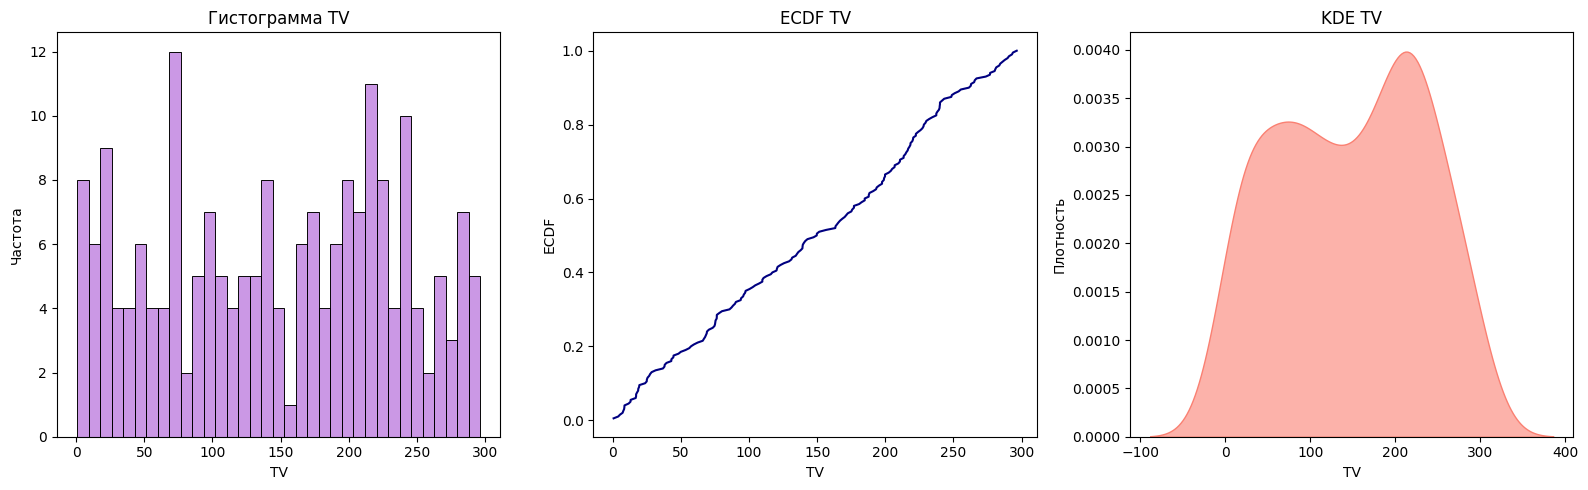

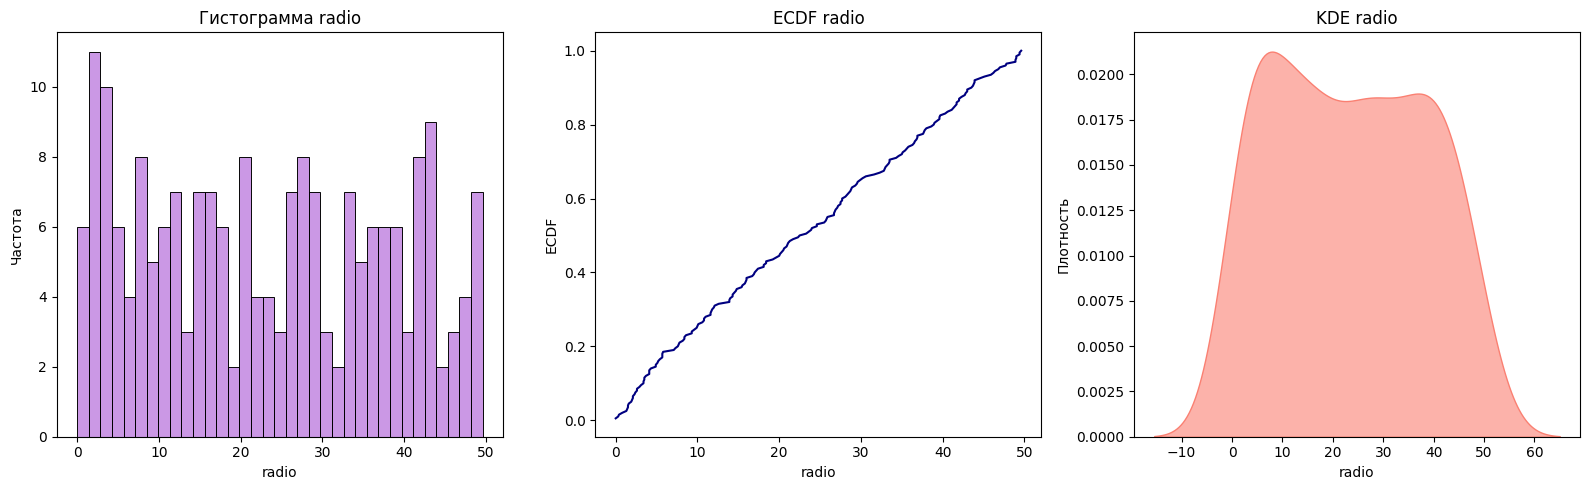

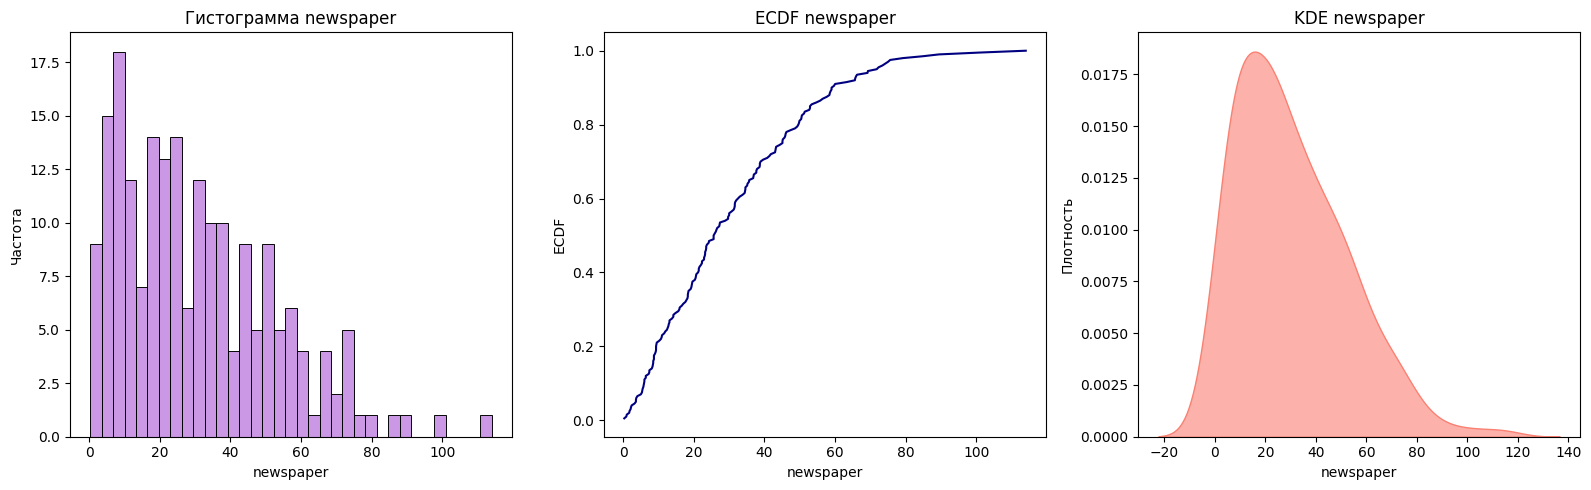

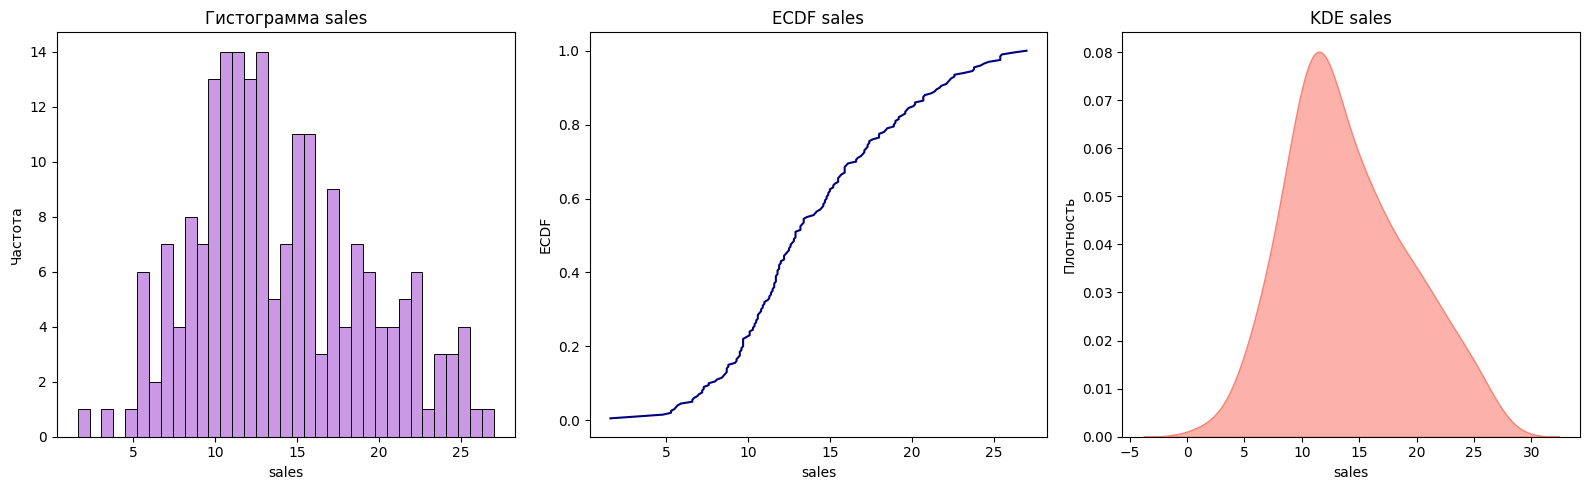

In [10]:
hist_ecdf_kde(reg_data)

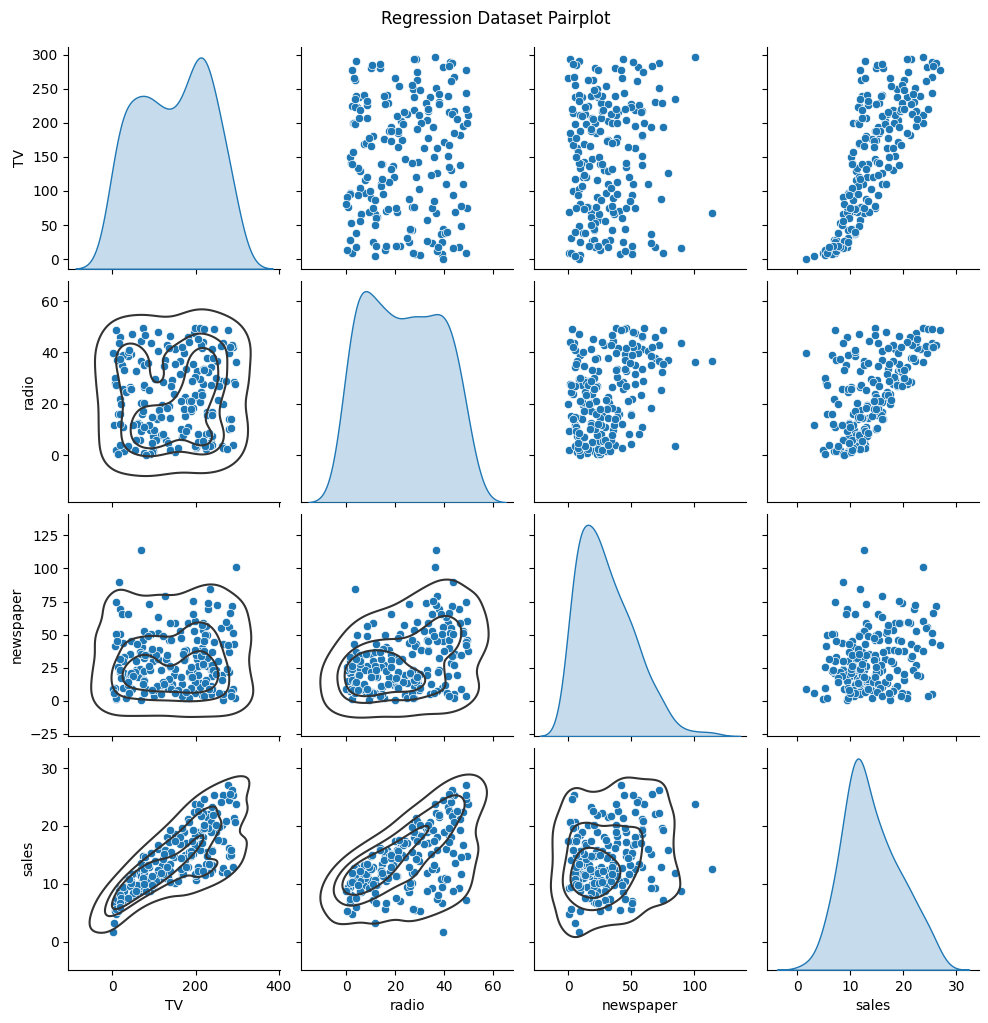

In [19]:
pairplot(reg_data, 'Regression Dataset')

Также построим матрицу корреляций между признаками:

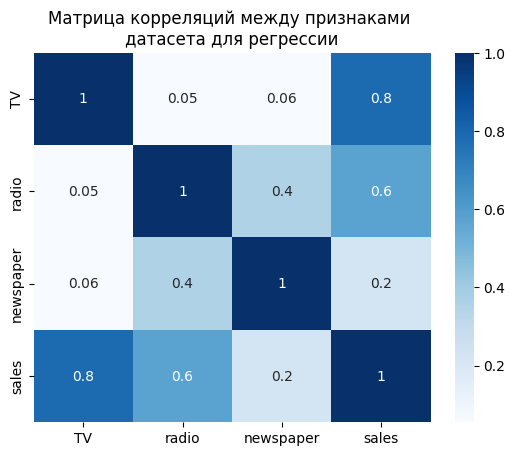

In [20]:
title = 'Матрица корреляций между признаками \nдатасета для регрессии'
corr_matrix(reg_data, 'pearson', title)

### Анализ датасета для классификации

Выполним аналогичные вычисления и построения для датасета для классификации:

In [21]:
class_statistics = statistics_measures(class_data).round(3)
class_statistics

age    sex     cp  trestbps      chol    fbs  restecg  \
Выборочное среднее  54.366  0.683  0.967   131.624   246.264  0.149    0.528   
Медиана             55.000  1.000  1.000   130.000   240.000  0.000    1.000   
Мода                58.000  1.000  0.000   120.000   197.000  0.000    1.000   
Дисперсия           82.485  0.217  1.065   307.586  2686.427  0.127    0.277   
СКО                  9.082  0.466  1.032    17.538    51.831  0.356    0.526   
Min-value           29.000  0.000  0.000    94.000   126.000  0.000    0.000   
Max-value           77.000  1.000  3.000   200.000   564.000  1.000    2.000   
IQR                 13.500  1.000  2.000    20.000    63.500  0.000    1.000   
Асимметрия          -0.201 -0.787  0.482     0.710     1.138  1.977    0.162   
Эксцесс             -0.553 -1.380 -1.193     0.894     4.412  1.908   -1.360   

                    thalach  exang  oldpeak  slope     ca   thal  target  
Выборочное среднее  149.647  0.327    1.040  1.399  0.729  2.314   0.545  
Медиана             153.000  0.000    0.800  1.000  0.000  2.000   1.000  
Мода                162.000  0.000    0.000  2.000  0.000  2.000   1.000  
Дисперсия           524.646  0.221    1.348  0.380  1.046  0.375   0.249  
СКО                  22.905  0.470    1.161  0.616  1.023  0.612   0.499  
Min-value            71.000  0.000    0.000  0.000  0.000  0.000   0.000  
Max-value           202.000  1.000    6.200  2.000  4.000  3.000   1.000  
IQR                  32.500  1.000    1.600  1.000  1.000  1.000   1.000  
Асимметрия           -0.535  0.739    1.263 -0.506  1.304 -0.474  -0.179  
Эксцесс              -0.081 -1.454    1.530 -0.637  0.806  0.273  -1.968

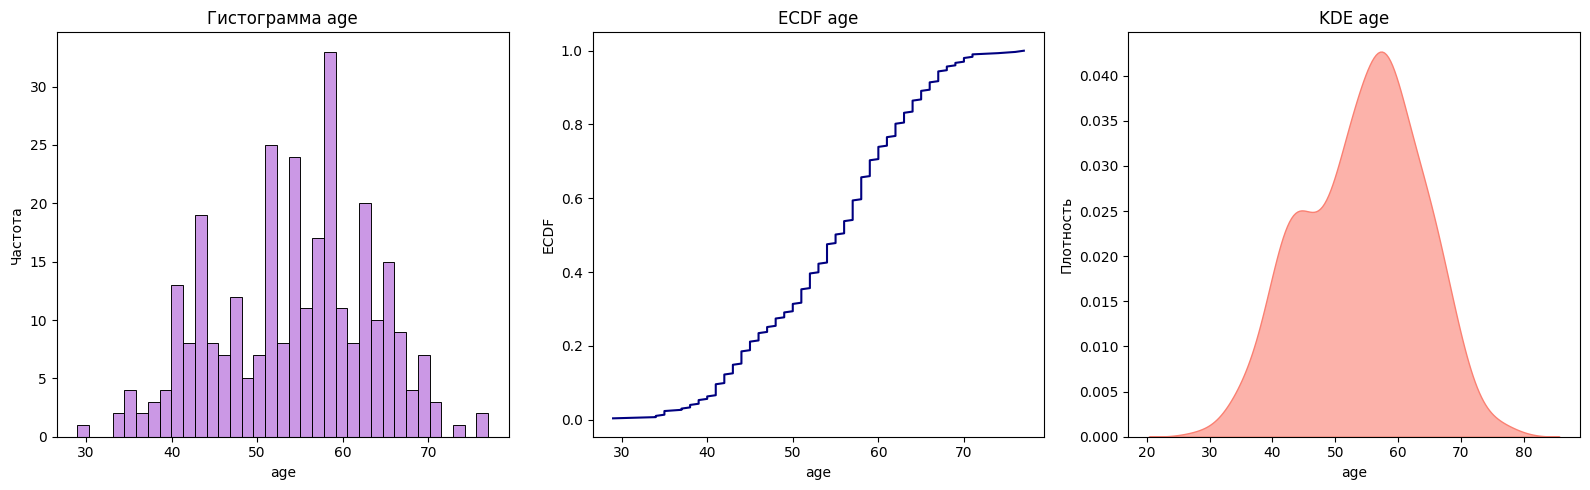

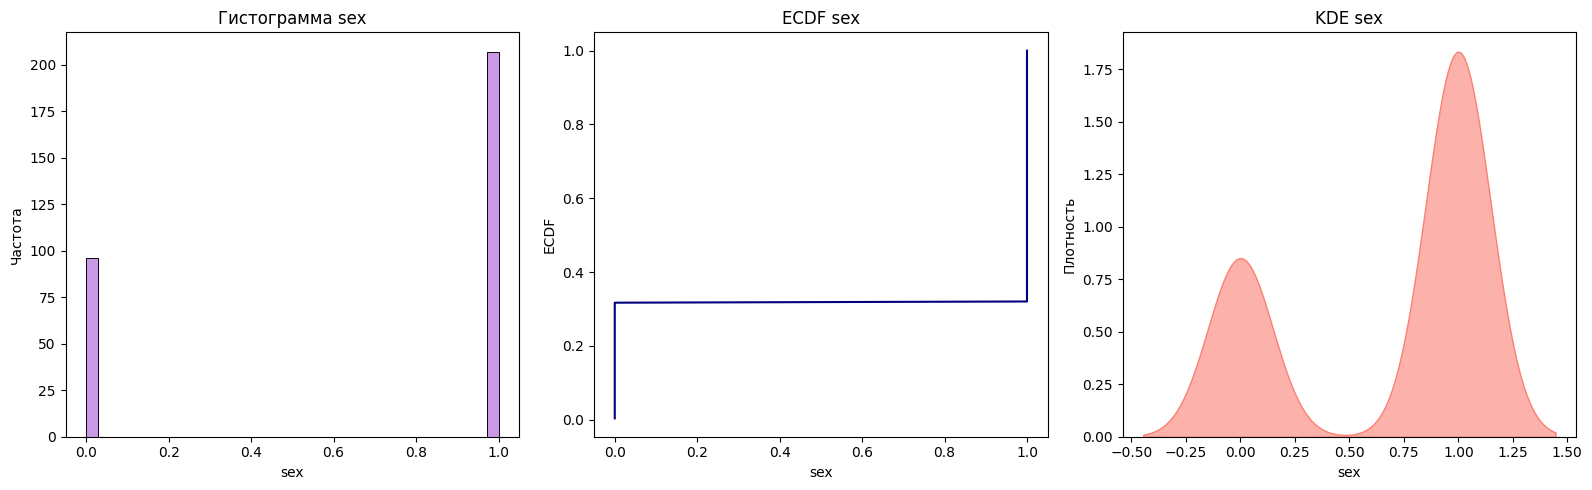

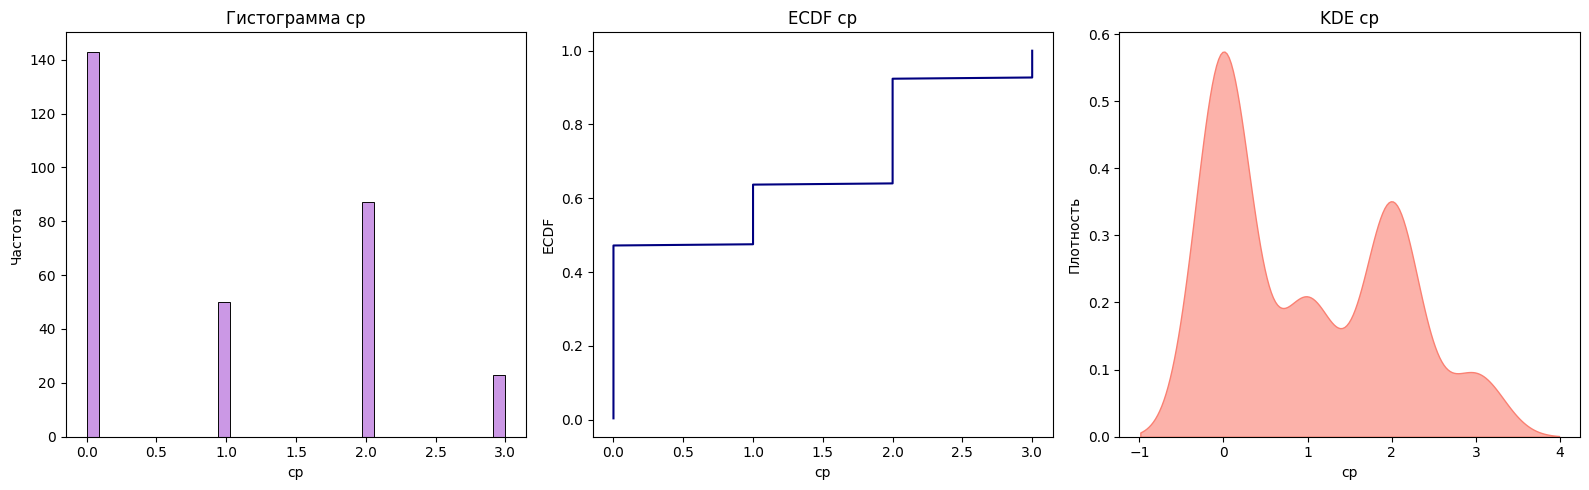

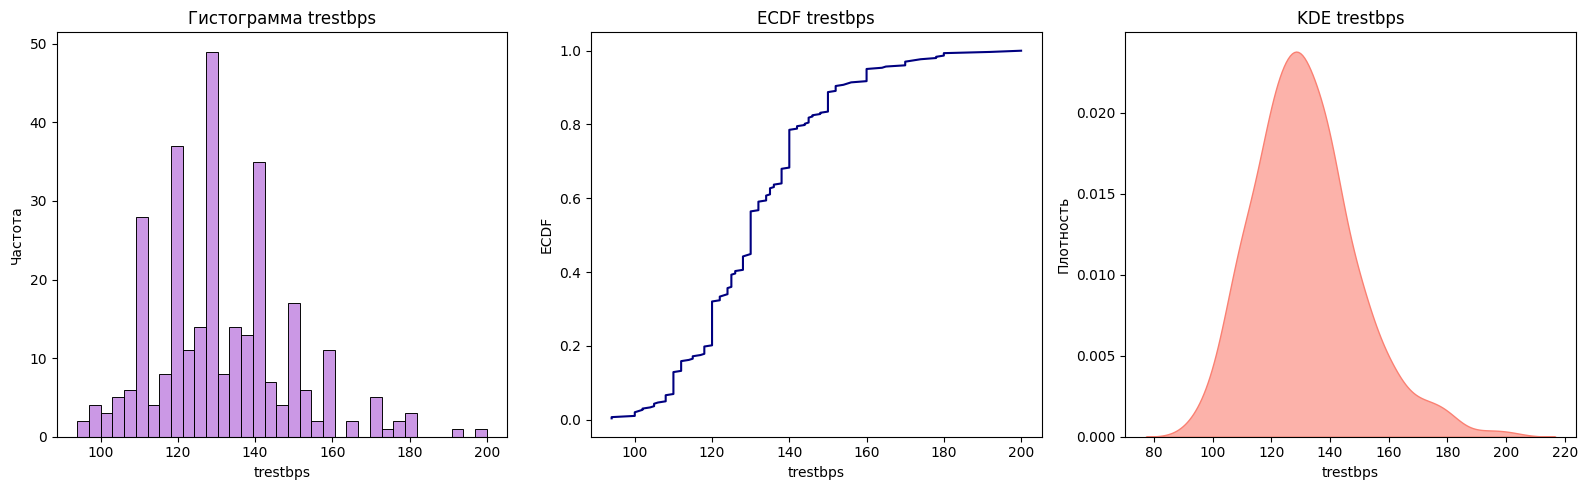

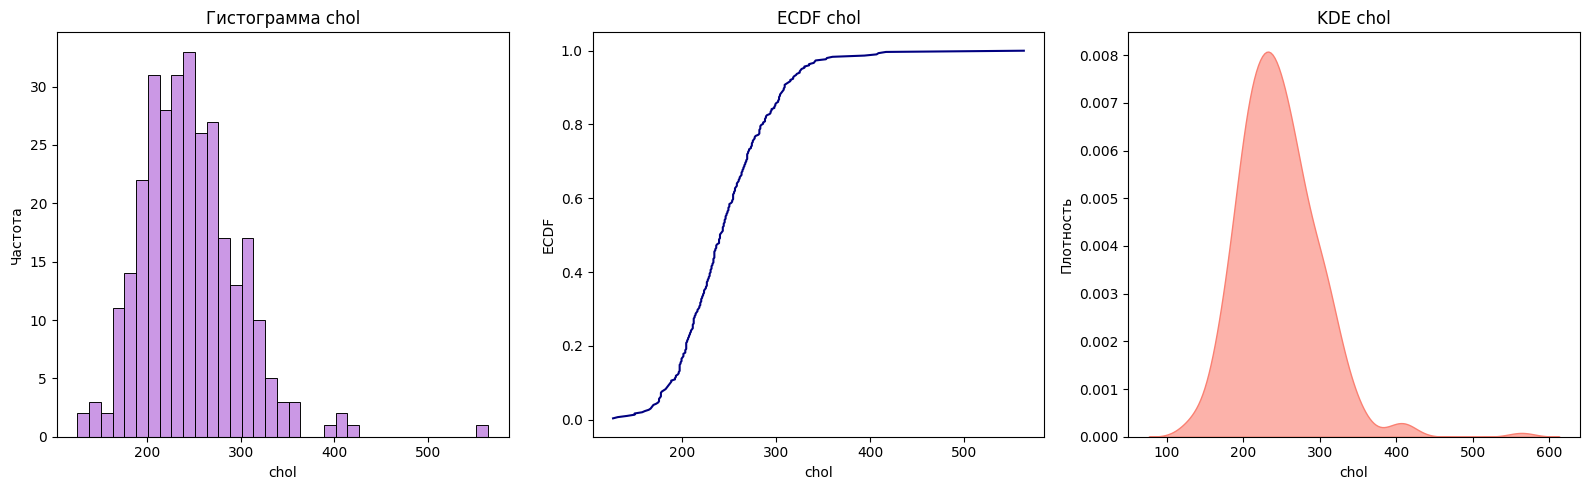

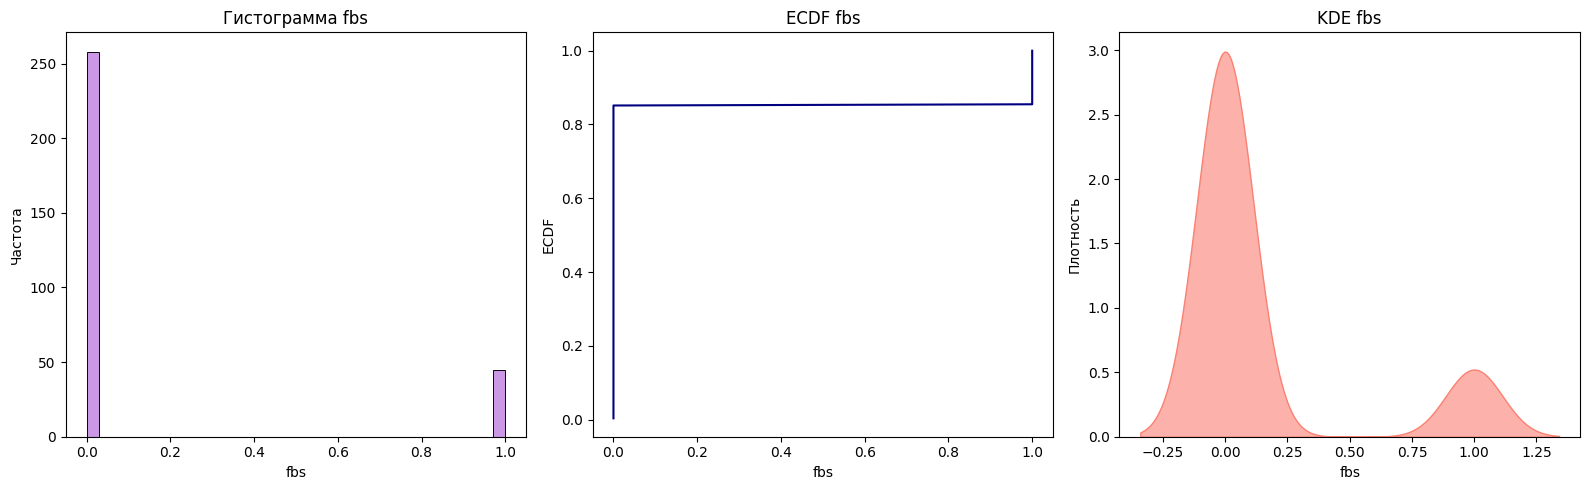

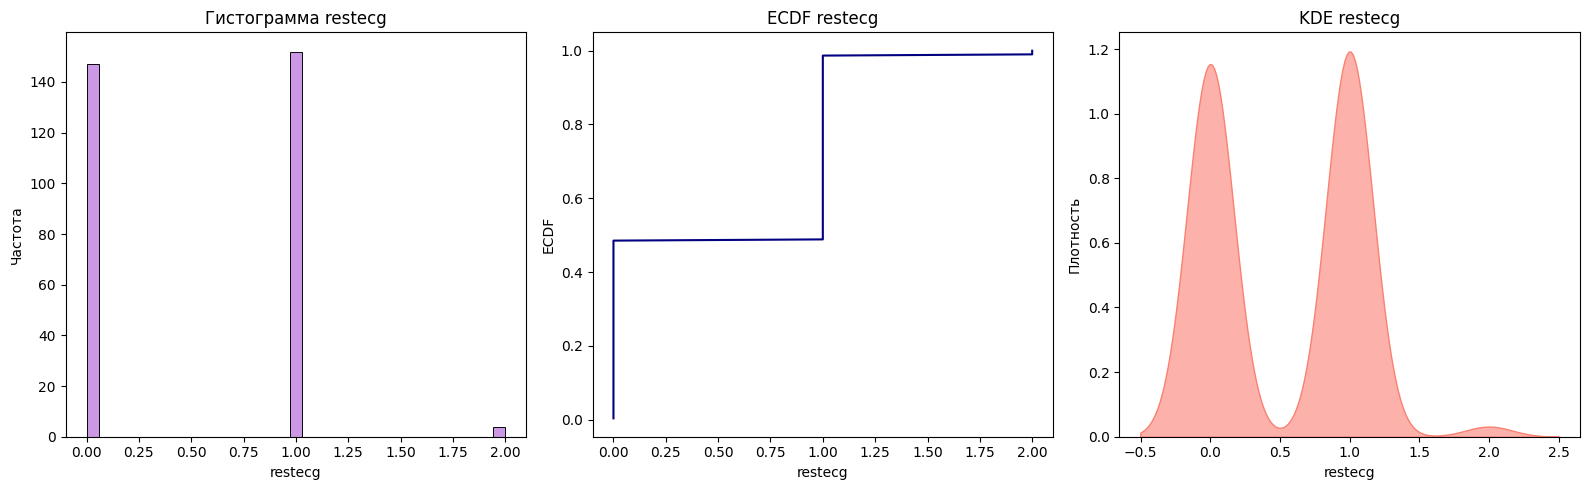

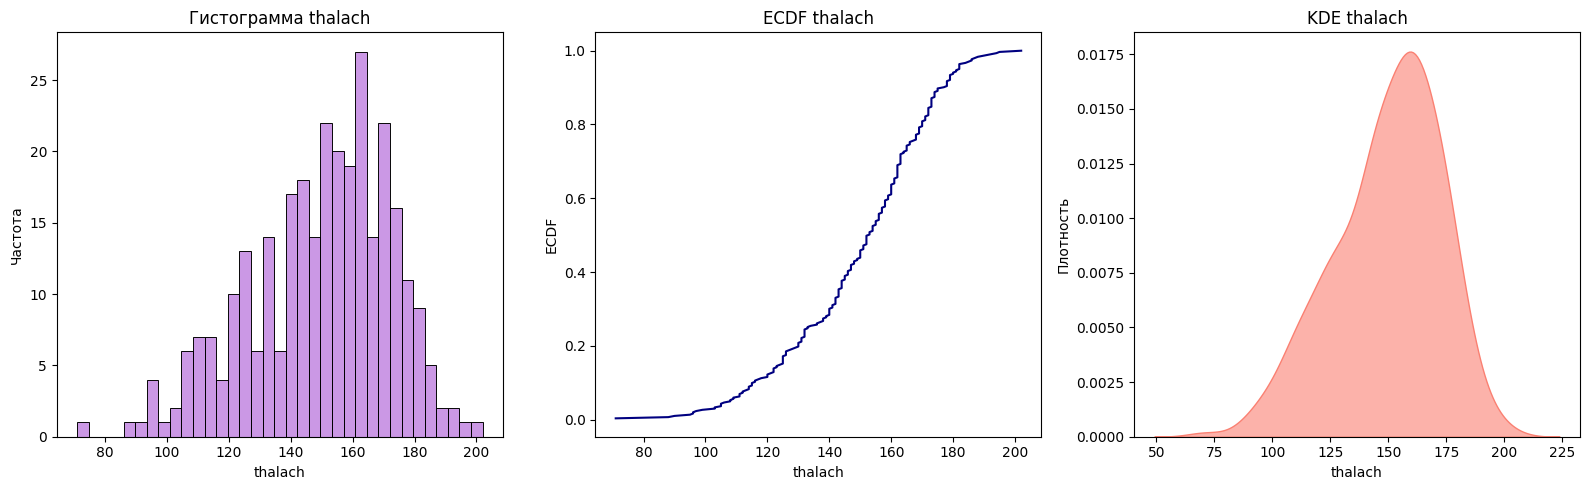

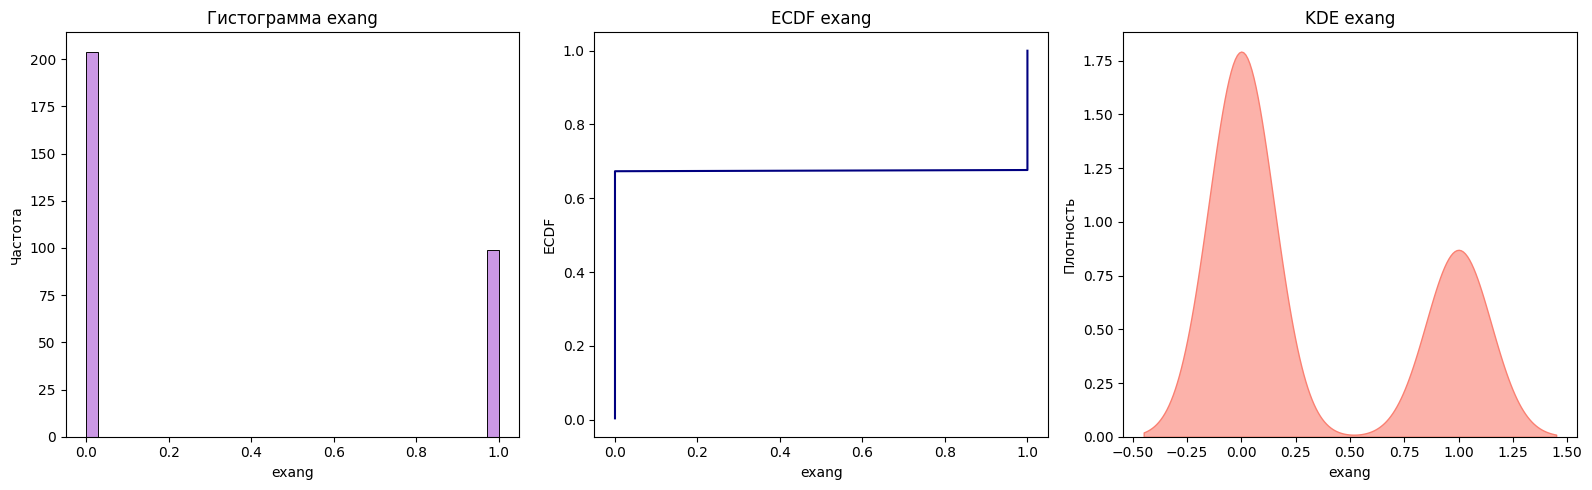

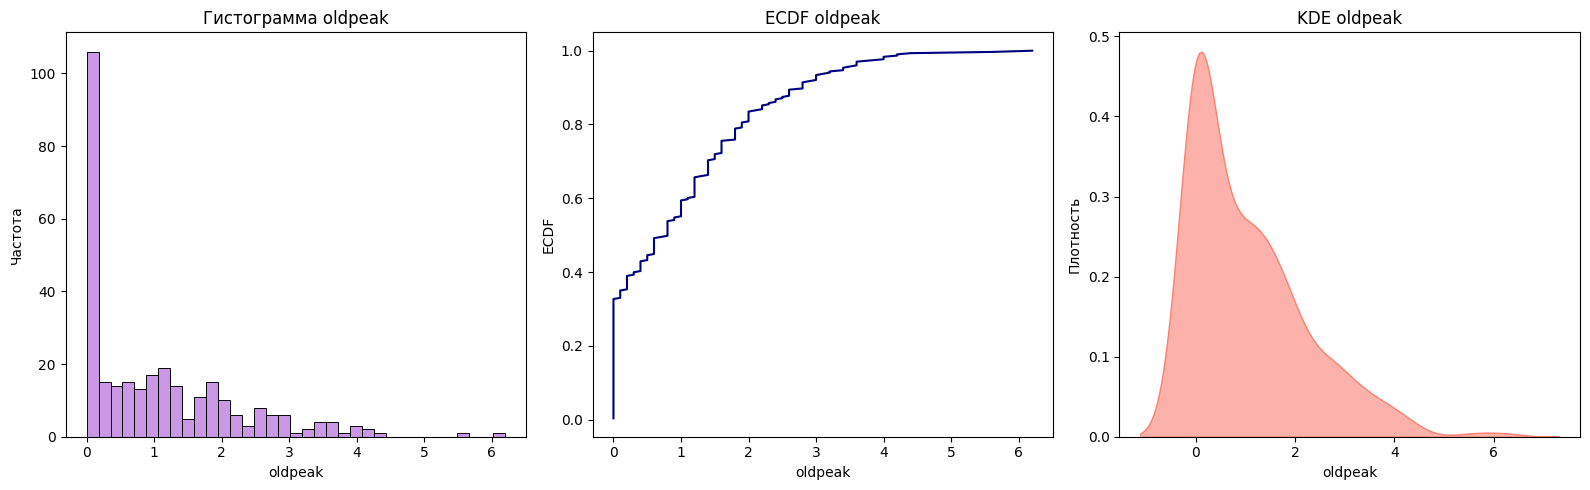

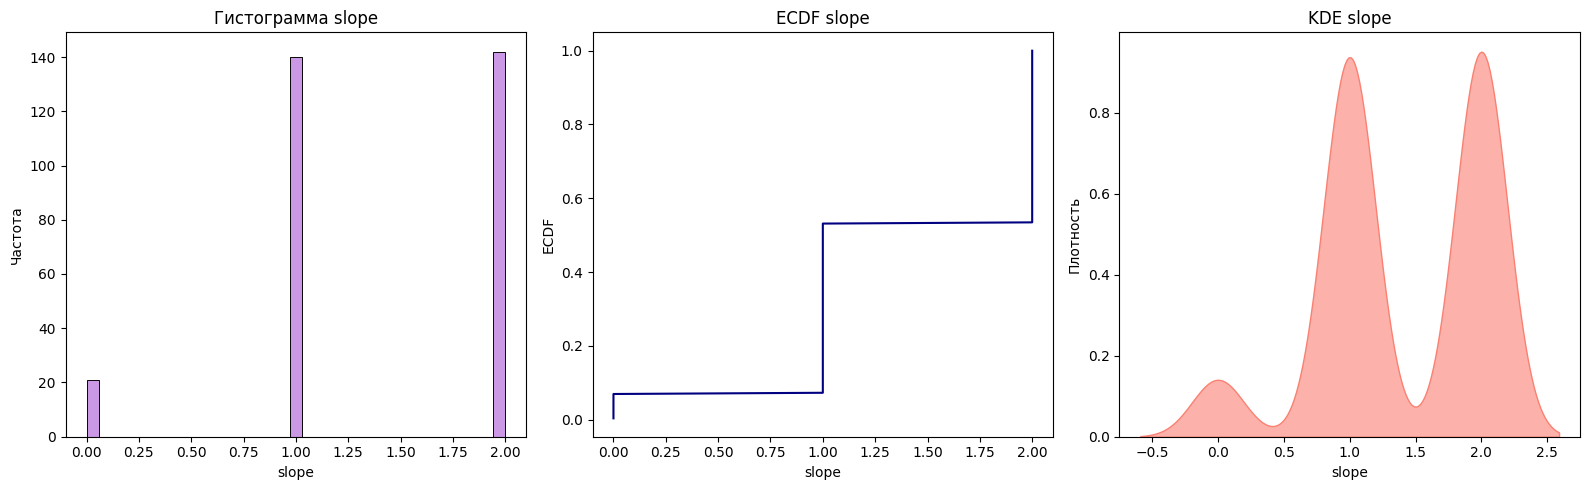

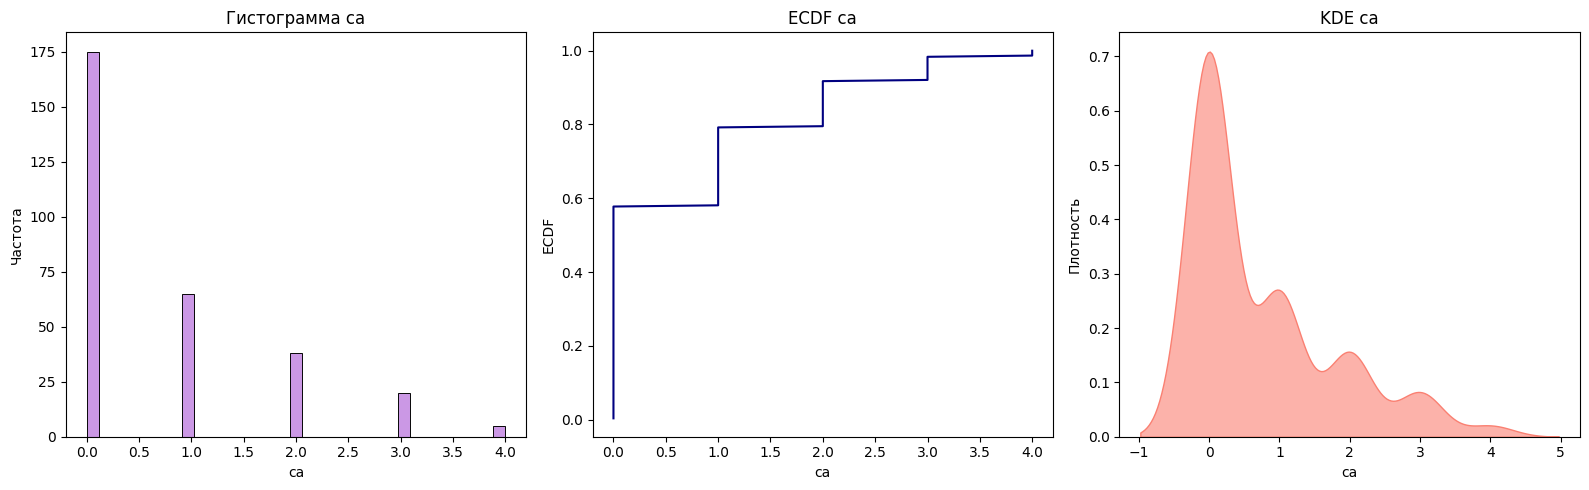

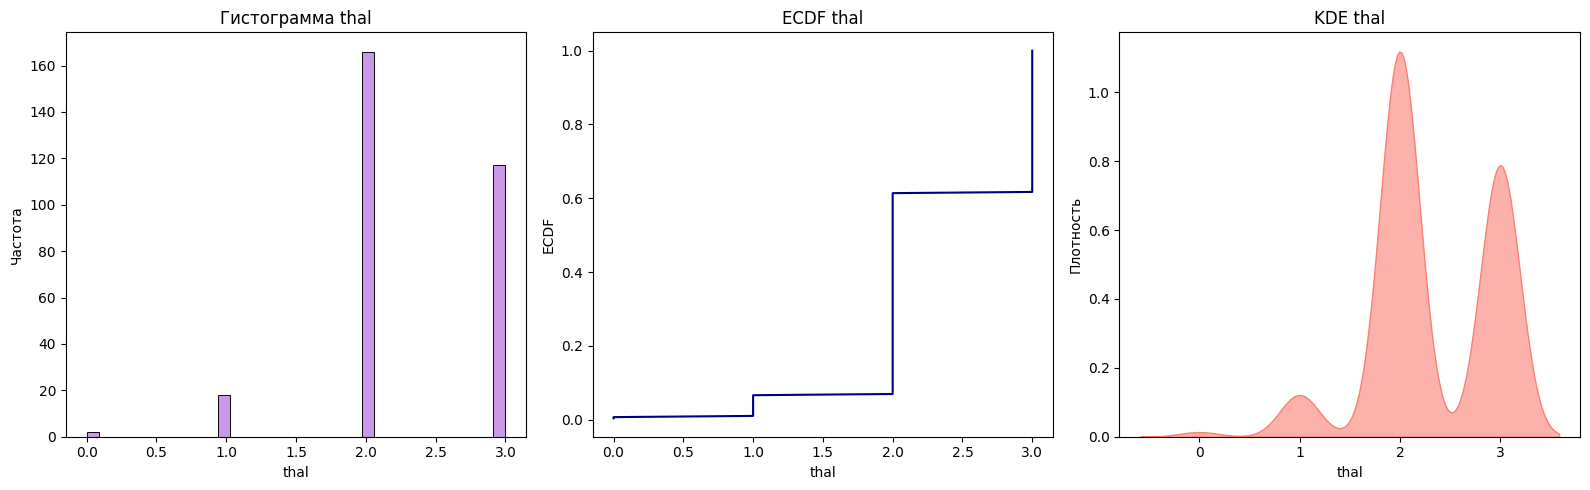

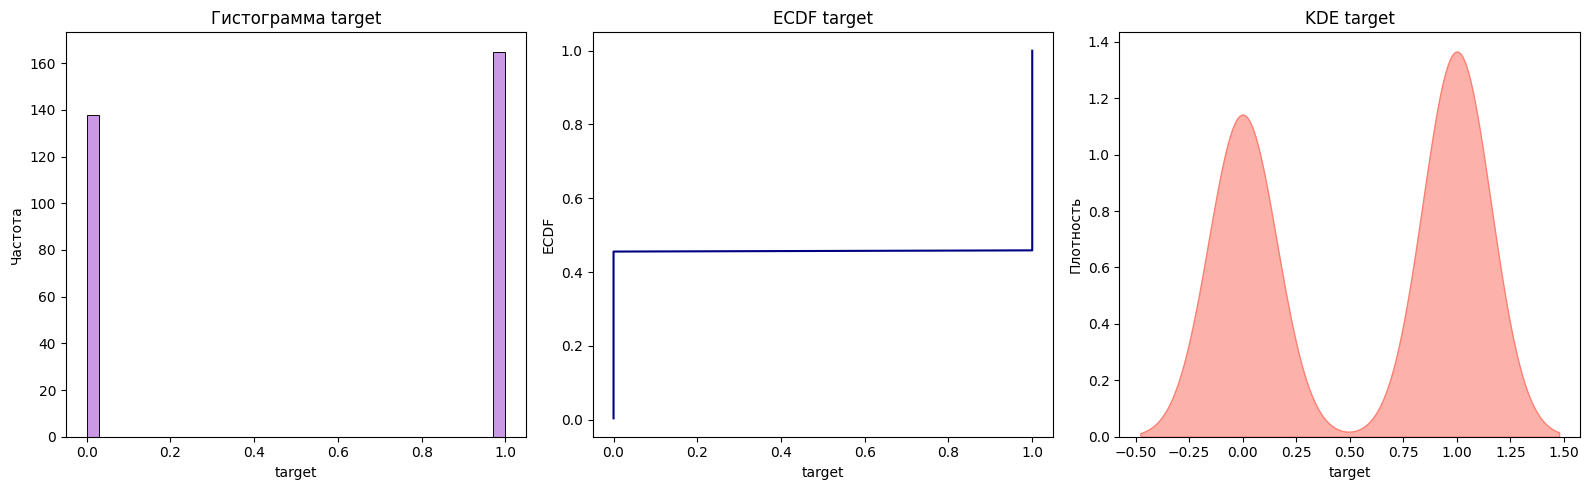

In [22]:
hist_ecdf_kde(class_data)

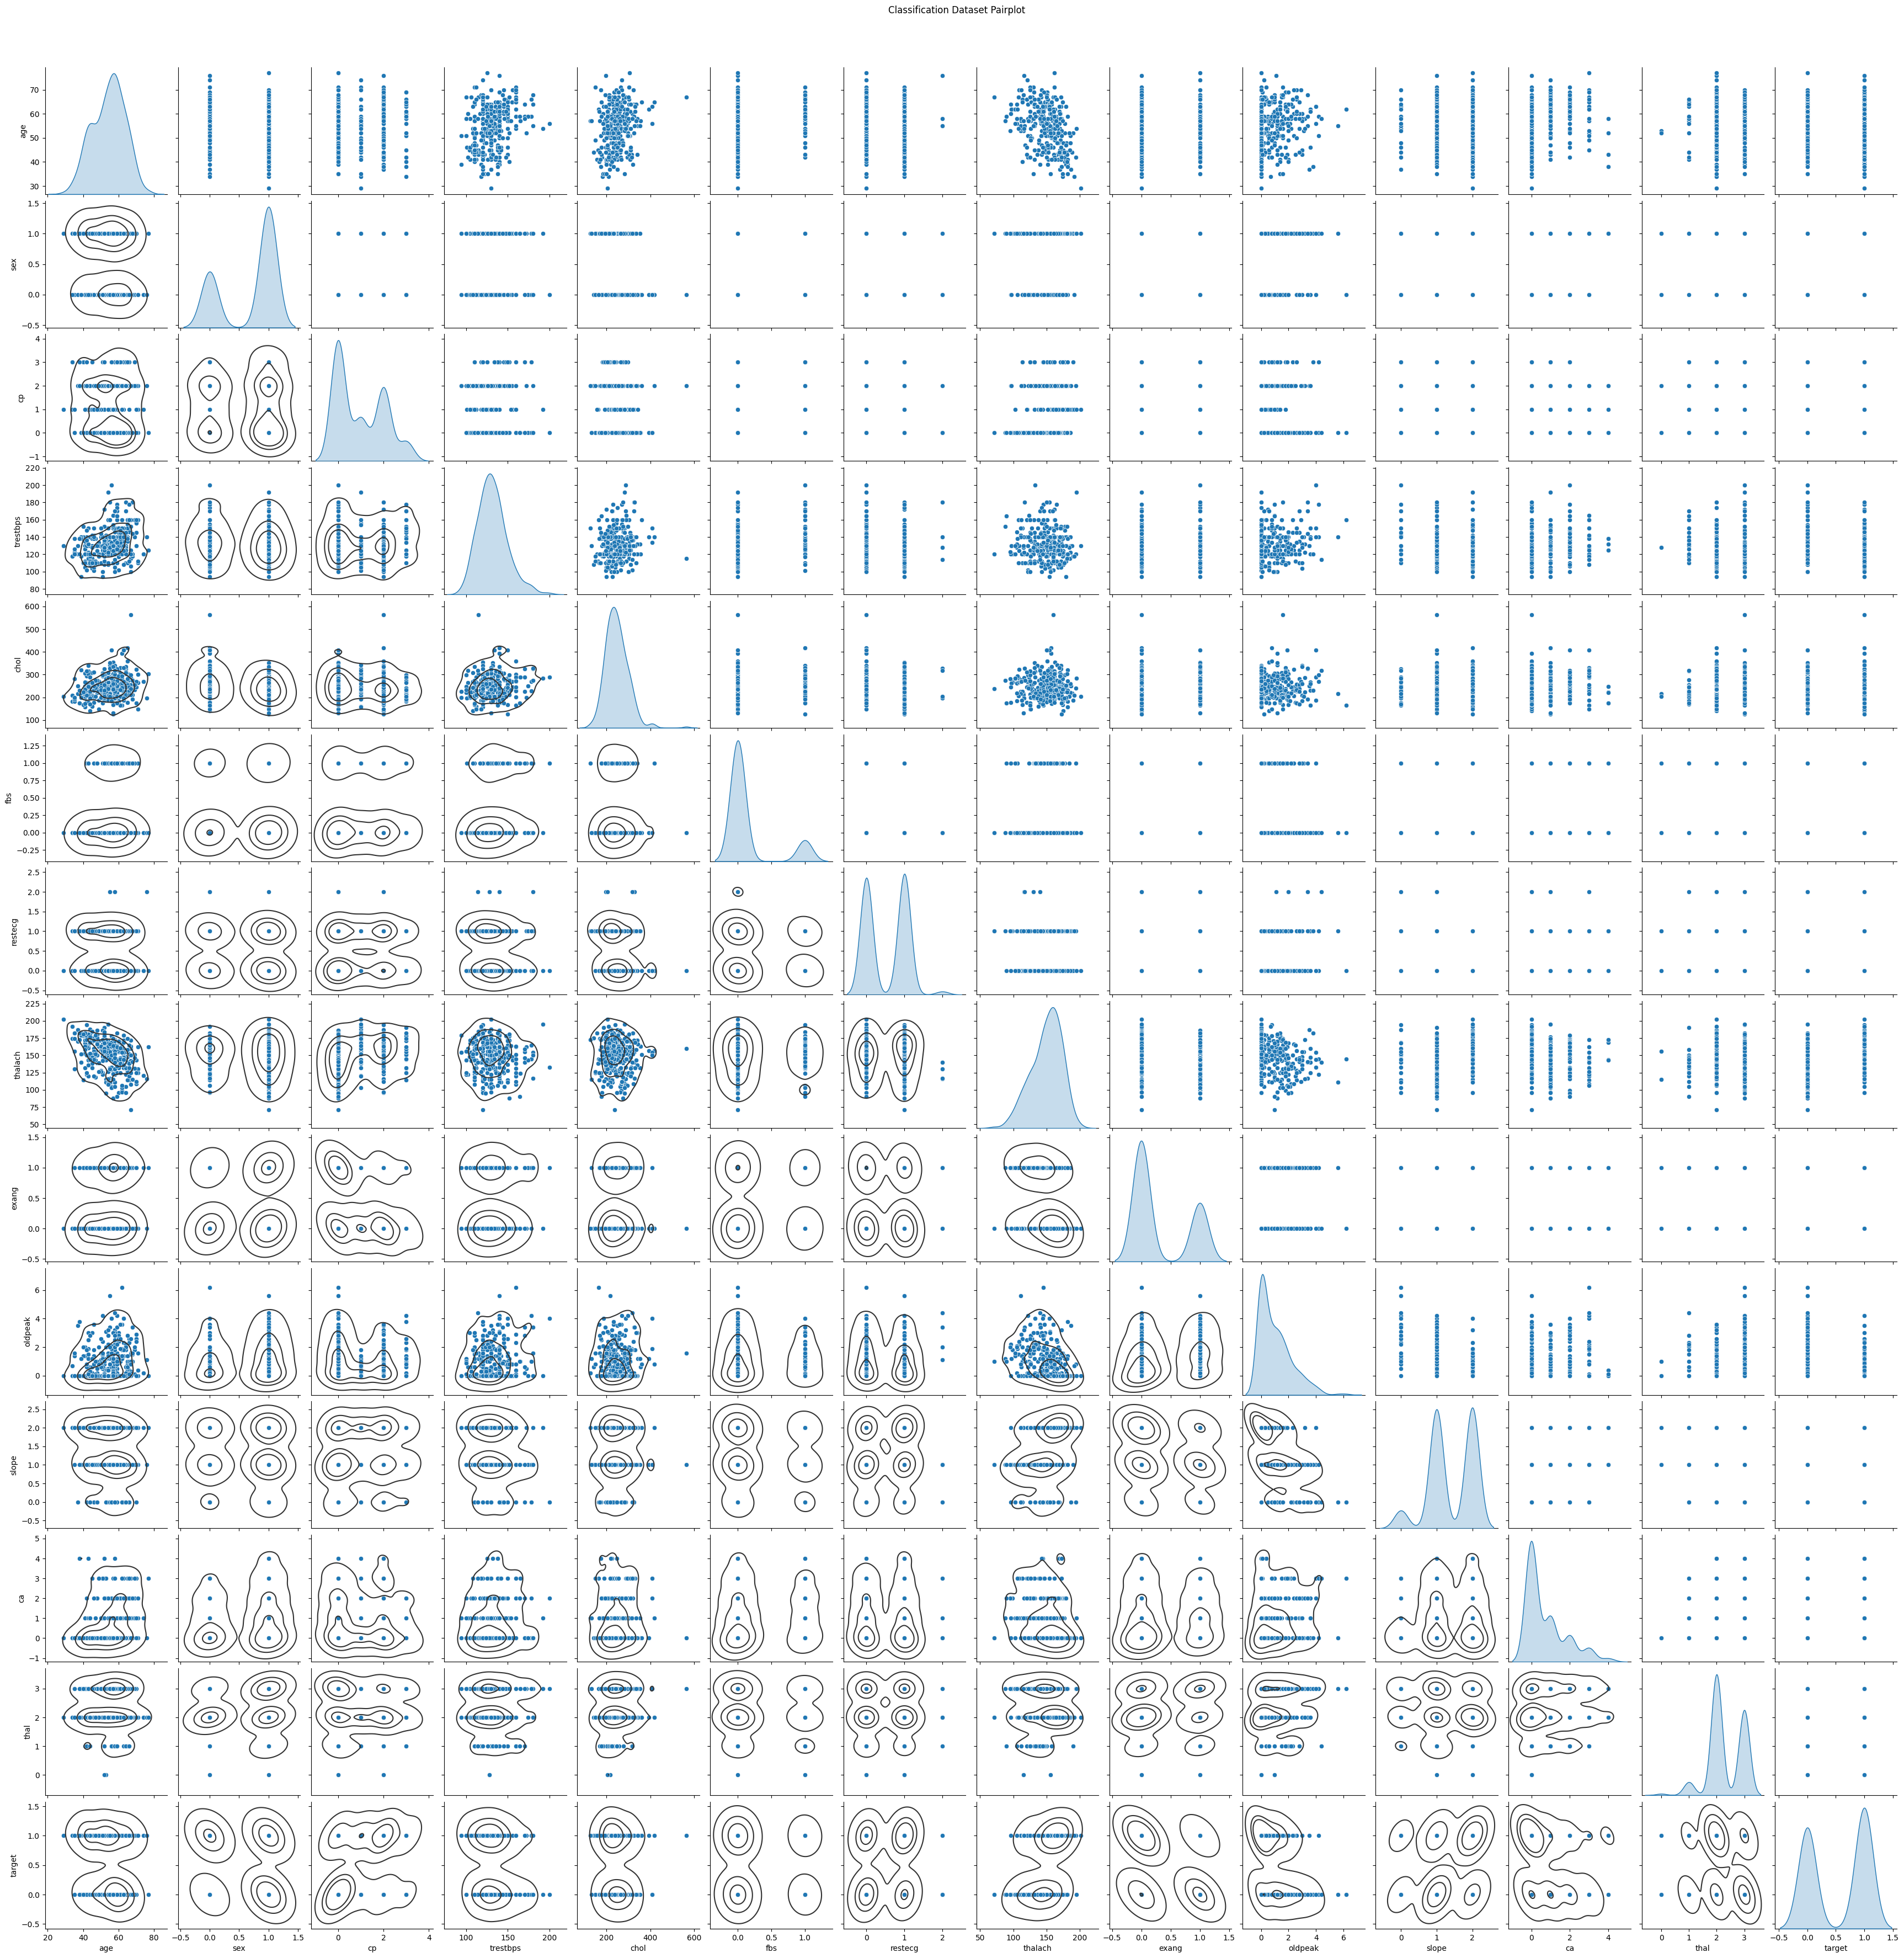

In [25]:
pairplot(class_data, 'Classification Dataset')

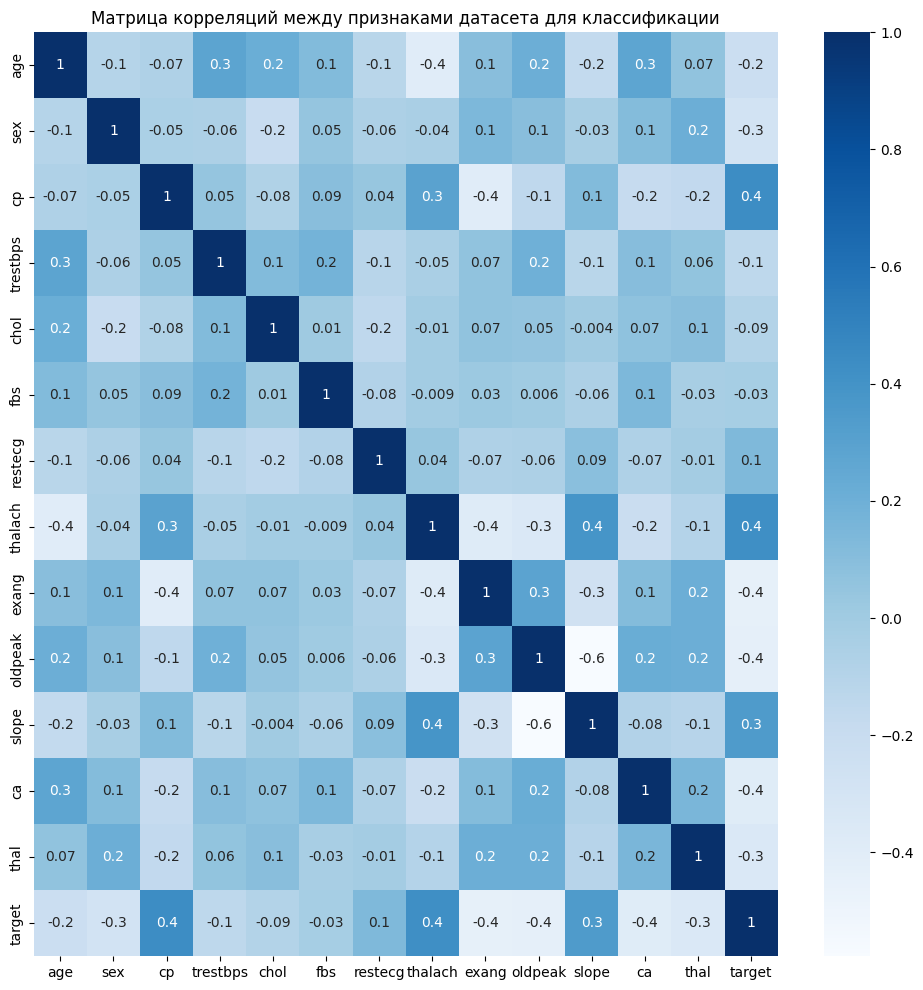

In [26]:
title = 'Матрица корреляций между признаками датасета для классификации'
plt.figure(figsize=(12, 12))
corr_matrix(class_data, 'pearson', title)

## **Исследование датасетов на работу с признаками**

### Feature Extraction

#### Извлечение новых признаков в датасете для регрессии

Зададим функцию `add_features`, реализующую добавление новых признаков. Суть этой функции в том, чтобы добавить взаимодействия между признаками (то есть одновременные затраты на рекламу на ТВ и по радио, к примеру), а также общие затраты независимо от их распределения между каналами рекламы.

In [27]:
def add_features(data, features):
    data['total_intersections'] = 1  # Взаимодействие между всеми признаками
    data['total_spent'] = 0  # Суммарные затраты
    for item1 in features:  # Создание новых признаков
        data['total_intersections'] *= data[item1]
        data['total_spent'] += data[item1]
        for item2 in features:
            if item1 == item2:
                data[f'{item1}^2'] = data[item1] ** 2
            elif f'{item2}/{item1}' not in data.keys():
                data[f'{item1}/{item2}'] = data[item1] * data[item2]
    return data

Применим это для извлечения новых признаков в датасете для регрессии. Так как исходный датасет содержит лишь три признака (`TV`, `radio` и `newspaper`, корреляция которых с продажами исследуется), применим функцию ко всем признакам и посмотрим на все взаимодействия.

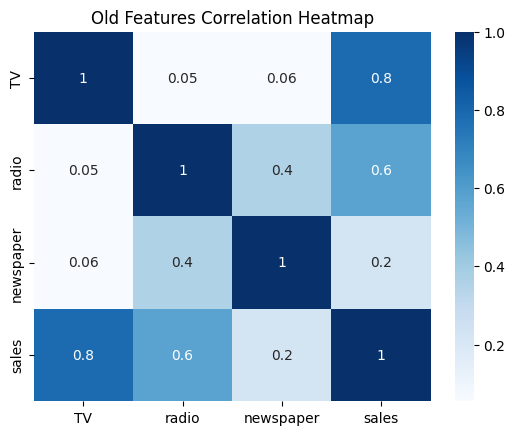

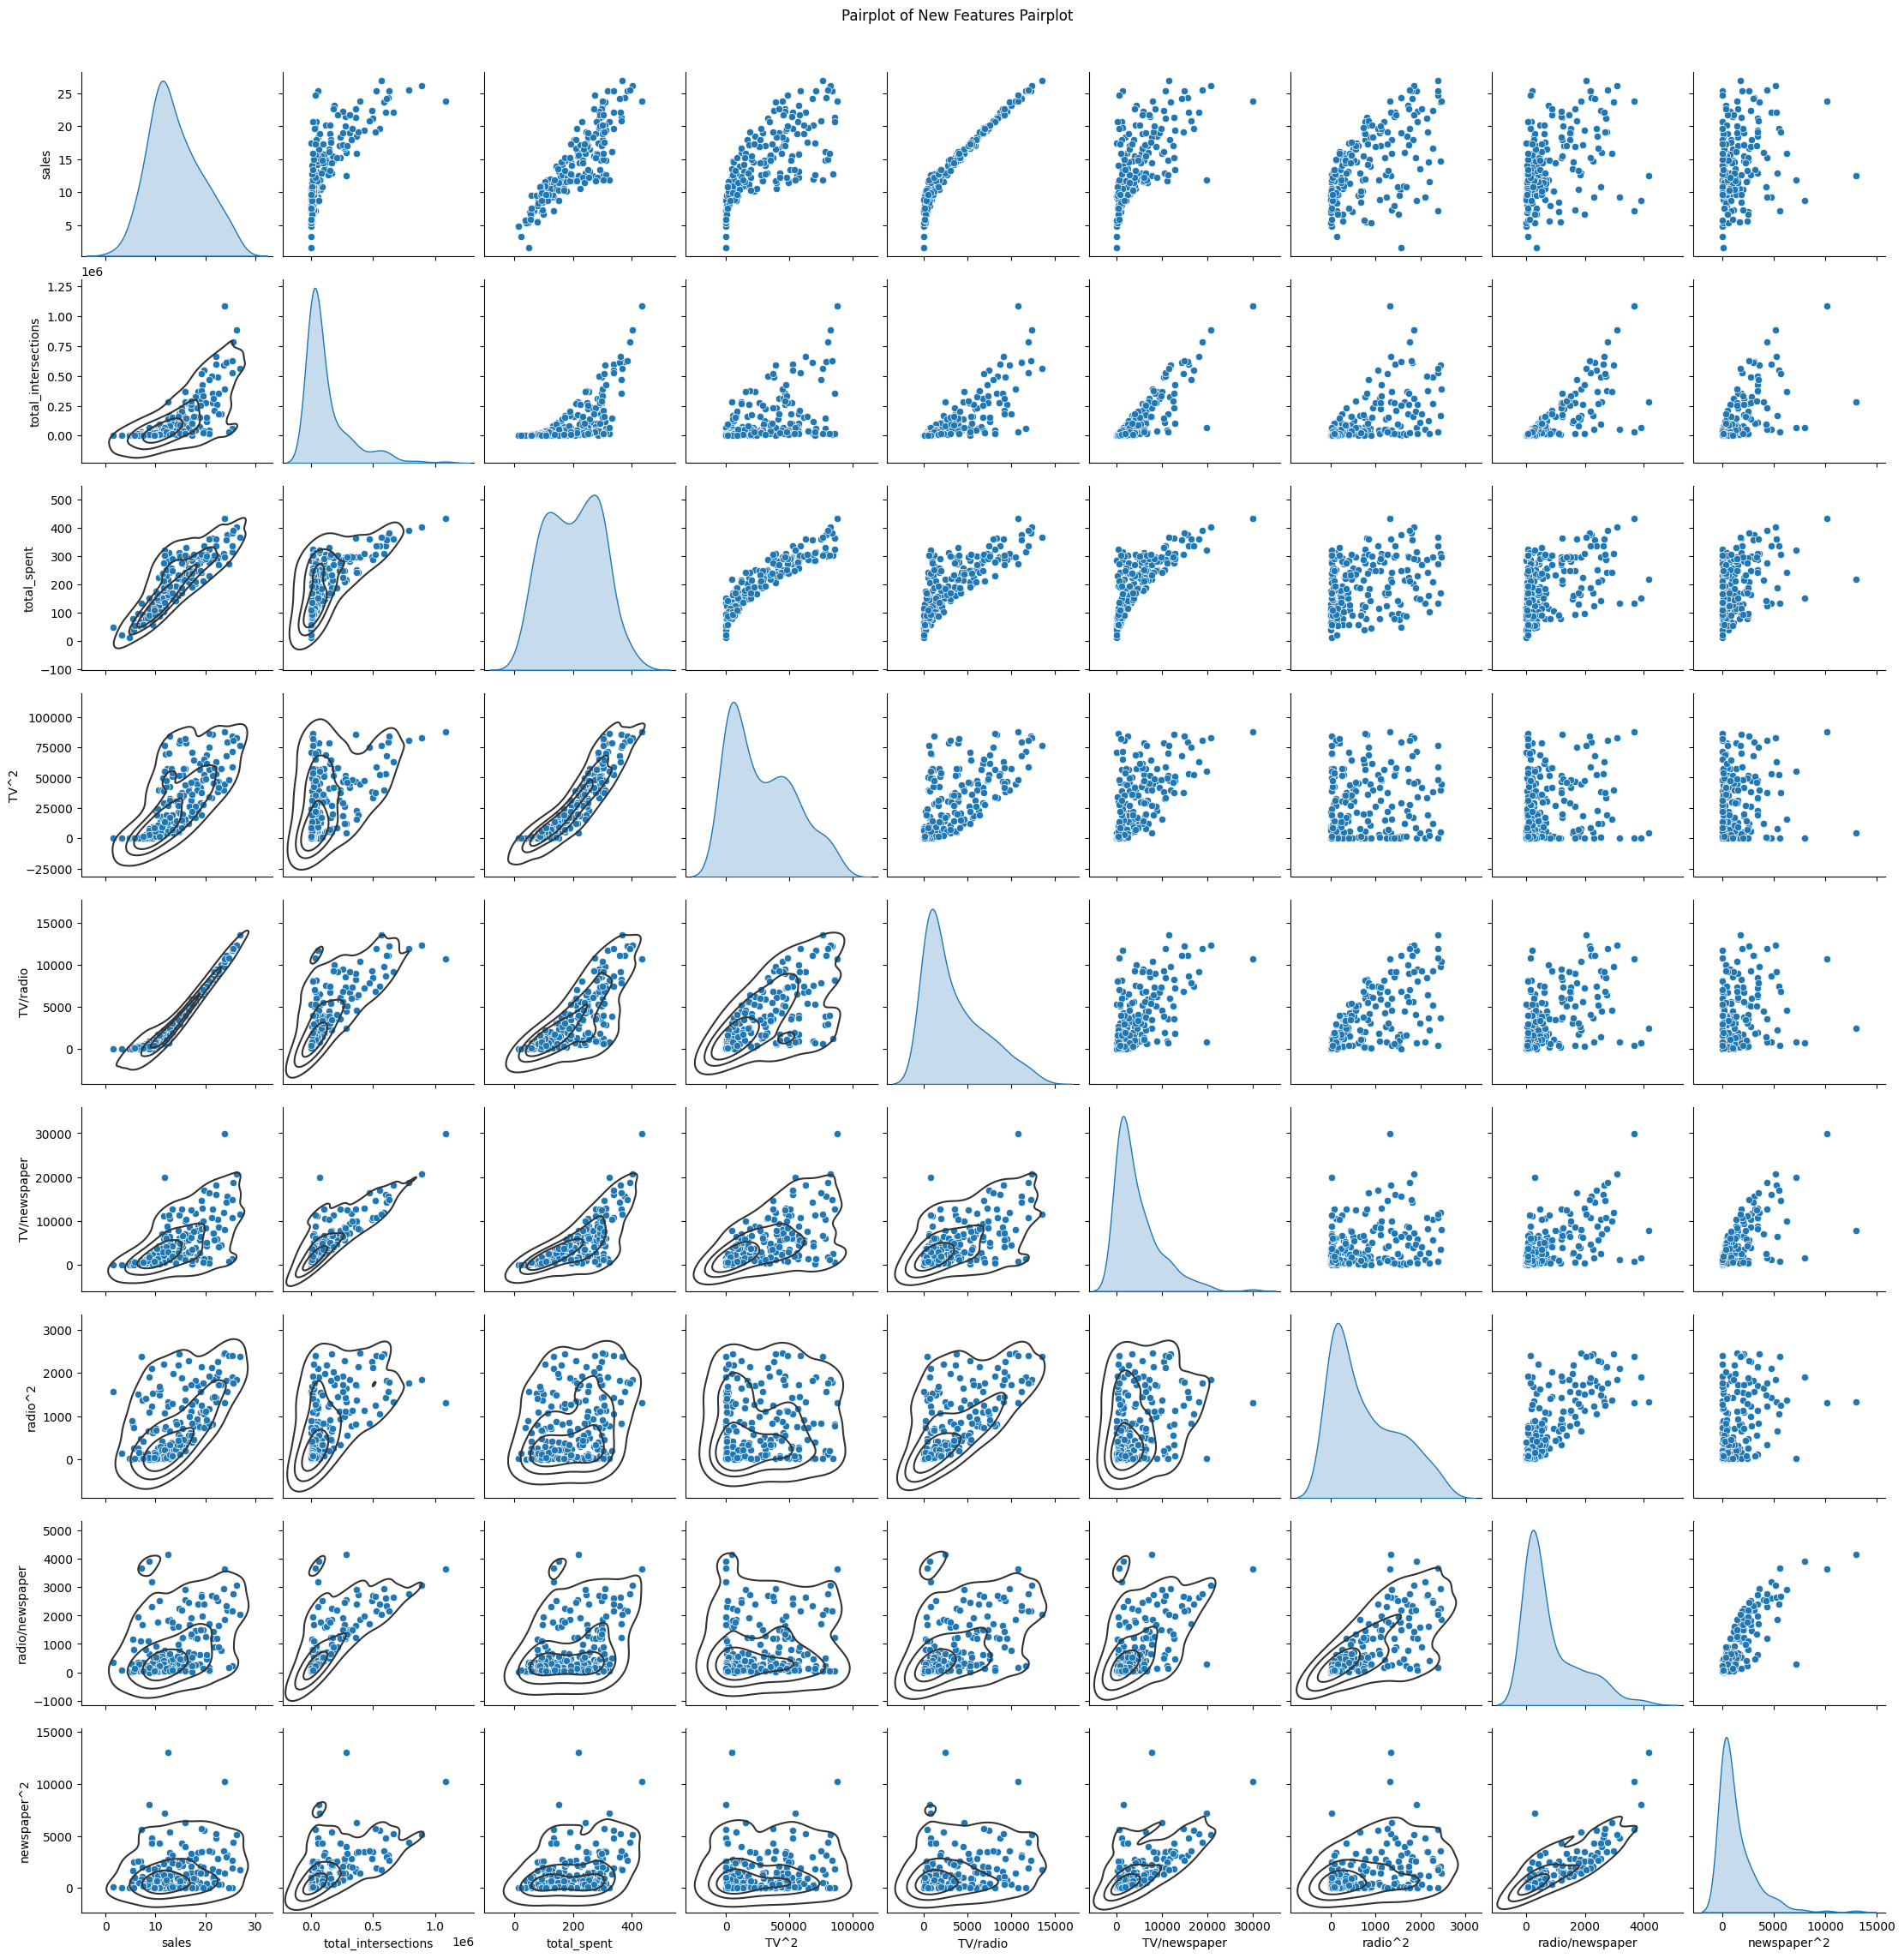

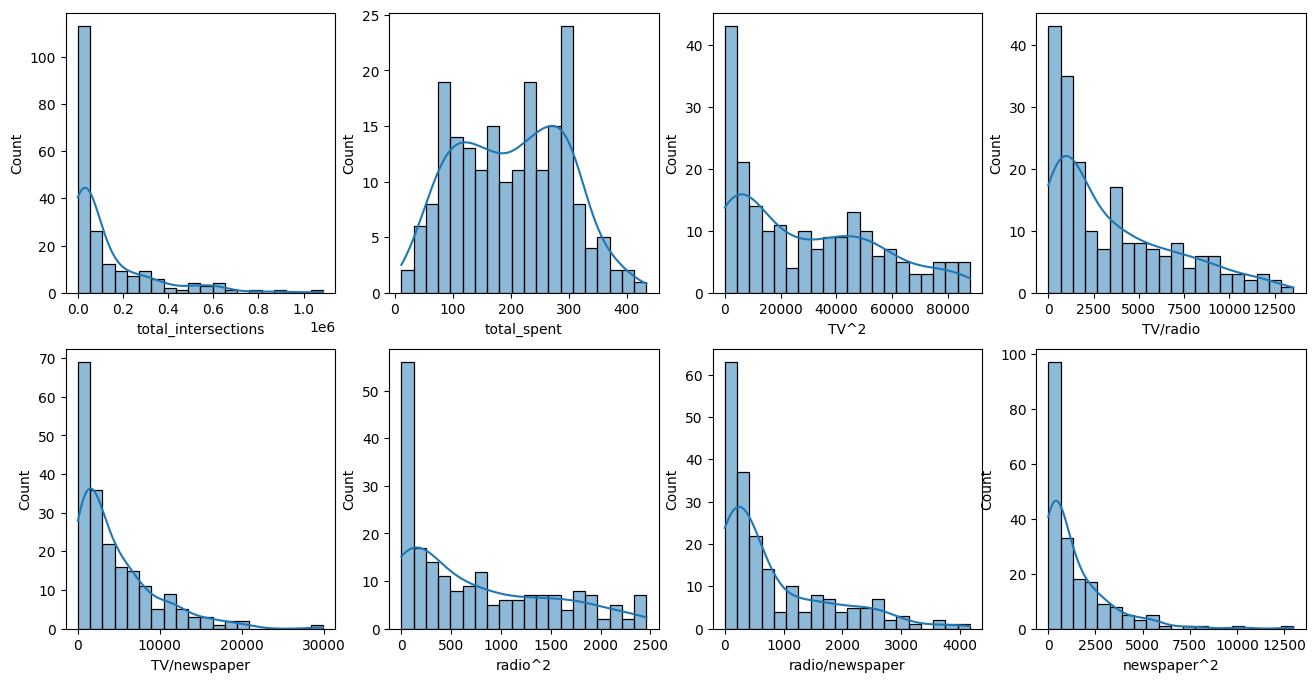

Корреляция признаков с продажами:
sales                  1.000000
TV/radio               0.963932
total_spent            0.867712
TV                     0.782224
TV^2                   0.735582
total_intersections    0.728699
TV/newspaper           0.618533
radio                  0.576223
radio^2                0.561608
radio/newspaper        0.415893
newspaper              0.228299
newspaper^2            0.215540
Name: sales, dtype: float64


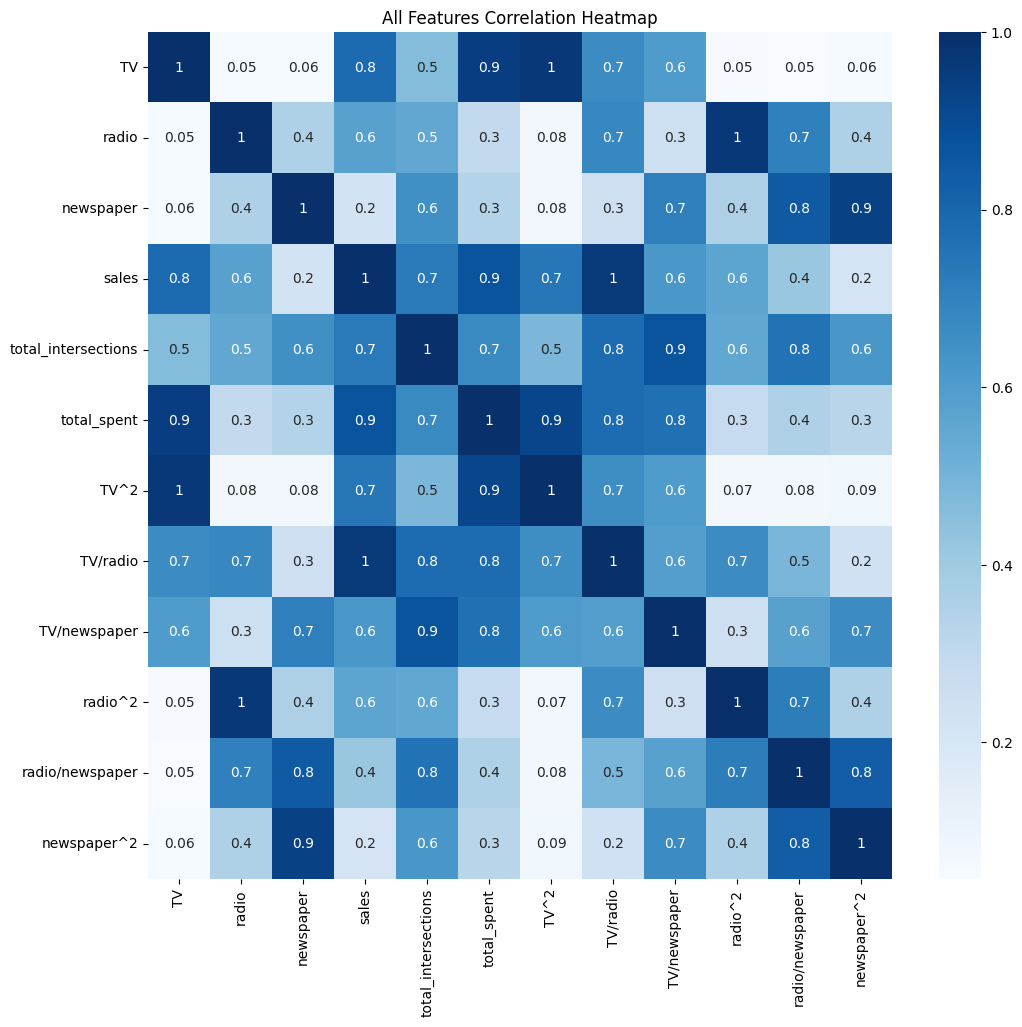

In [28]:
reg_data = pd.read_csv('advertising.csv')

corr_matrix(reg_data, 'pearson', 'Old Features Correlation Heatmap')  # Матрица корреляций для существующих признаков

# Добавление новых признаков
features = []
for item in reg_data:
    features.append(item)
reg_data = add_features(reg_data, features[:3])

# Построение pairplot для новых признаков
pairplot(reg_data[reg_data.keys()[3:]], 'Pairplot of New Features')

# Вывод гистограмм и KDE для новых признаков
plt.figure(figsize=(16, 8))
for i, column in enumerate(reg_data.keys()[4:], 1):
    plt.subplot(2, 4, i)
    sns.histplot(reg_data[column], kde=True, bins=20)
plt.show()

# Вывод значений корреляций и построение матрицы корреляций для всех признаков, включая новые
correlation_with_sales = reg_data.corr()['sales'].sort_values(ascending=False)
print("Корреляция признаков с продажами:")
print(correlation_with_sales)
plt.figure(figsize=(12, 11))
corr_matrix(reg_data, 'pearson', 'All Features Correlation Heatmap')

Как можно заметить, наилучшими из добавленных признаков стали `TV/radio`, `total_spent` и `TV^2`.

#### Извлечение новых признаков в датасете для классификации

Проделаем похожие действия с датасетом для классификации. Наша задача в перспективе – обучить модель так, чтобы она предсказывала параметр `target` $\in {0, 1}$ по определенным признакам. Так, для оптимизации процесса извлечения новых признаков необходимо *(интуитивно)* понять, какие признаки при взаимодействии могут давать бОльшую вероятность наличия заболевания.

Так, выделим признаки, корреляция которых с целевой переменной по модулю наибольшая:

1.	`cp` (тип боли в груди, корреляция 0.43);
2.	`thalach` (максимальный пульс, корреляция 0.42);
3.	`oldpeak` (пиковые значения в ЭКГ при физической нагрузке по сравнению с покоем, корреляция -0.43);
4.	`exang` (наличие ангины, вызванной физическими нагрузками, корреляция -0.44);
5.	`slope` (наклон пикового значения в ЭКГ при физической нагрузке, корреляция 0.35);
6.	`ca` (количество крупных окрашенных сосудов при флурозопии, корреляция -0.39);
7.	`thal` (тип дефекта, корреляция -0.34).

Так, можно рассмотреть следующие взаимодействия указанных выше признаков для исследования возможности извлечения новых признаков, имеющих высокую корреляцию с целевой переменной:

1.  `cp` и `thalach`: как тип боли в груди связан с максимальным пульсом;
2.  `oldpeak` и `slope`: комбинированный эффект характеристик ЭКГ на риск заболевания;
3.  `exang` и `thal`: влияние ангины при физической нагрузке и типа дефекта;
4.  `ca` и `oldpeak`: связь между количеством сосудов и изменениями на ЭКГ;
5.  `thalach`, `oldpeak` и `slope`: исследование взаимосвязи всего, что связано напрямую с работой сердца.

***Примечание:*** *так как для датасета классификации мы самостоятельно подобрали комбинации признаков интуитивно, мы не будет использовать заданную функцию `add_features`, а пропишем взаимодействия вручную. Кроме этого, в качестве извлекаемых признаков мы будем рассматривать только взаимодействия вида $a \cdot b$, нелинейные комбинации не будут использованы.*

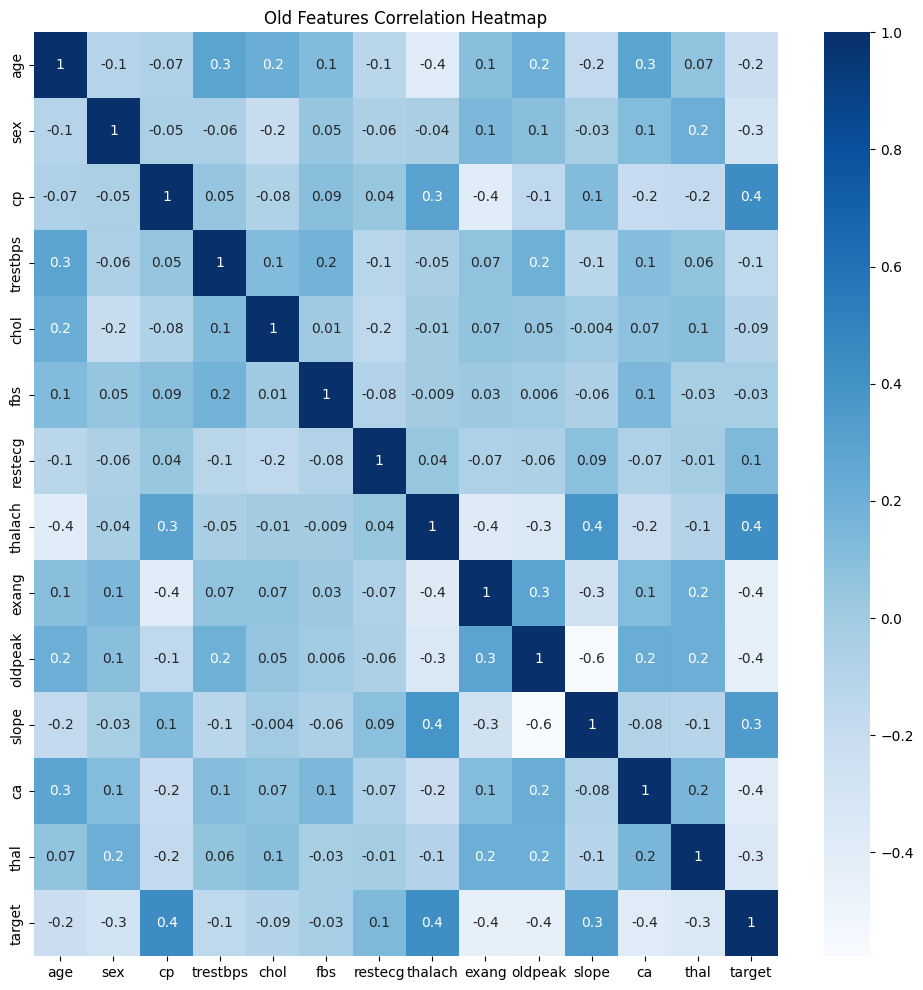

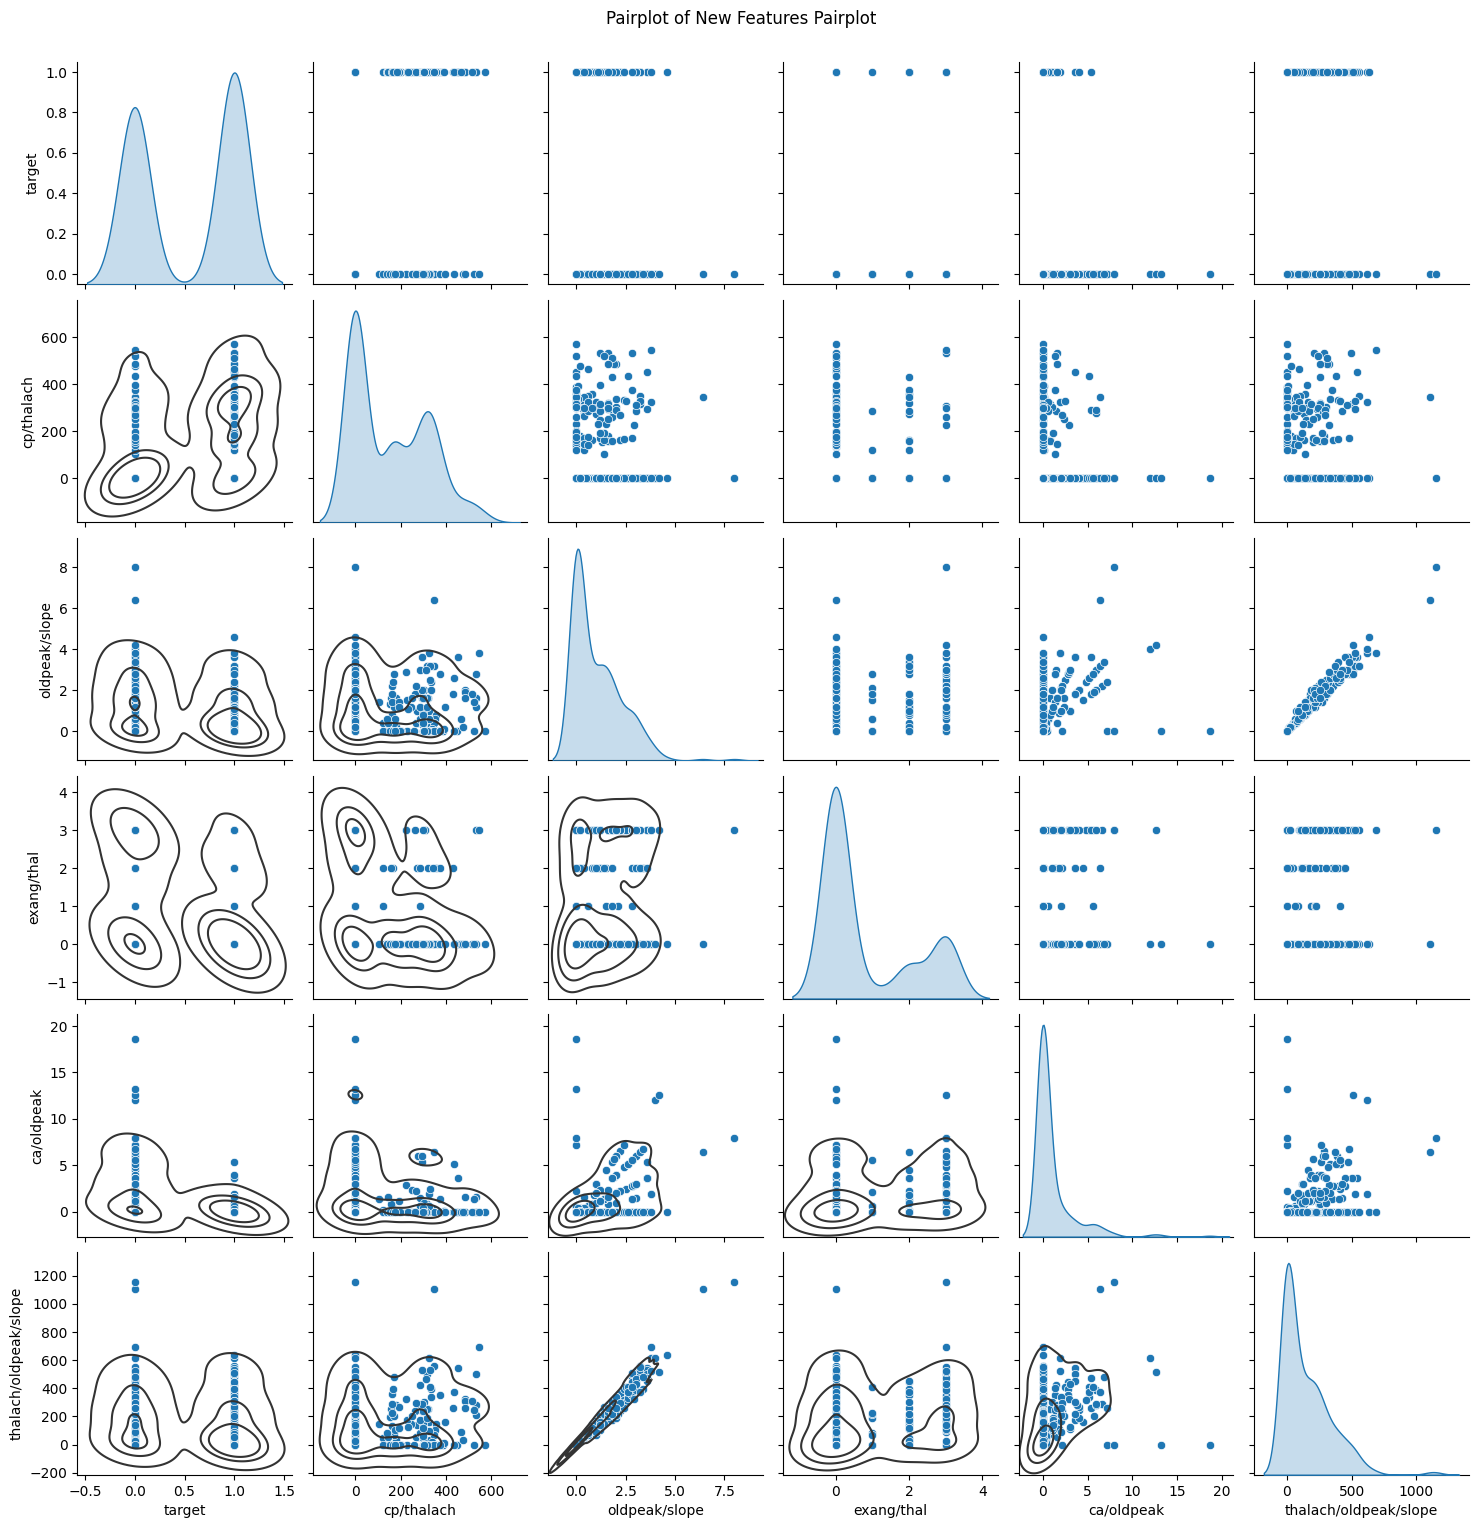

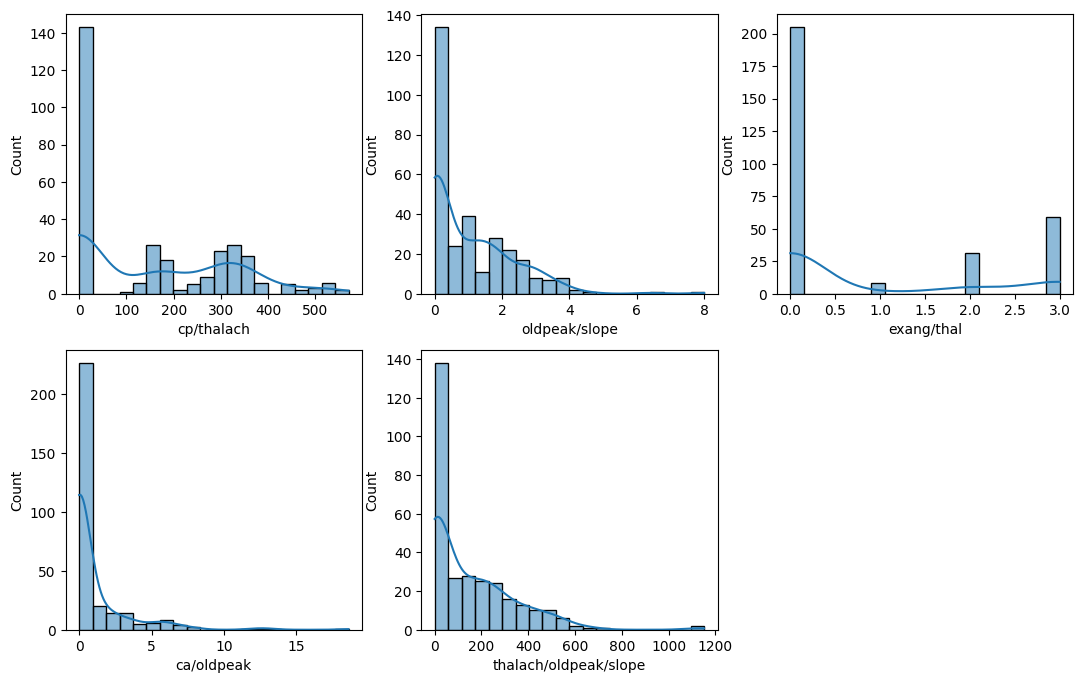

Корреляция признаков с целевой переменной:
target                   1.000000
cp/thalach               0.453050
cp                       0.433798
thalach                  0.421741
slope                    0.345877
restecg                  0.137230
fbs                     -0.028046
chol                    -0.085239
trestbps                -0.144931
age                     -0.225439
thalach/oldpeak/slope   -0.234588
sex                     -0.280937
oldpeak/slope           -0.293896
thal                    -0.344029
ca                      -0.391724
ca/oldpeak              -0.407785
oldpeak                 -0.430696
exang                   -0.436757
exang/thal              -0.448328
Name: target, dtype: float64


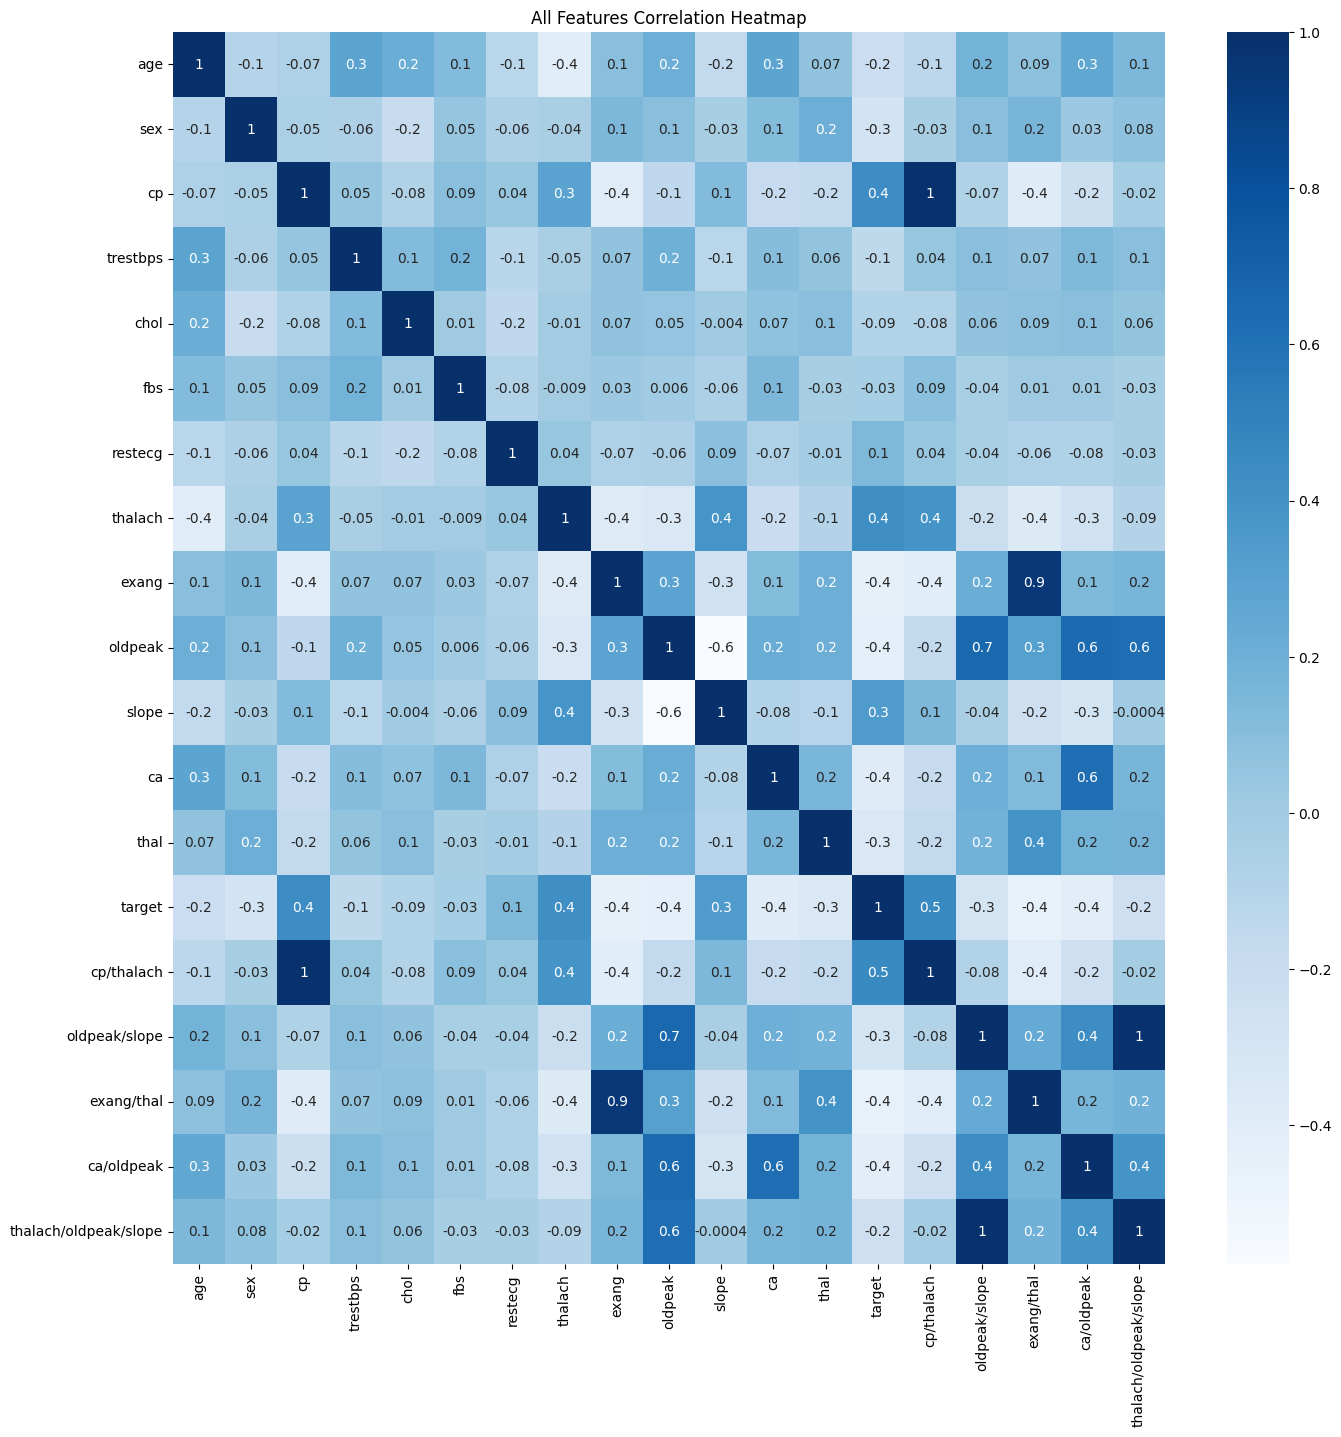

In [29]:
class_data = pd.read_csv('heart.csv')

plt.figure(figsize=(12, 12))
corr_matrix(class_data, 'pearson', 'Old Features Correlation Heatmap')  # Матрица корреляций для существующих признаков

# Добавление новых признаков
def add_2intersec_feature(feat1, feat2):
    class_data[f'{feat1}/{feat2}'] = class_data[feat1] * class_data[feat2]

add_2intersec_feature('cp', 'thalach')
add_2intersec_feature('oldpeak', 'slope')
add_2intersec_feature('exang', 'thal')
add_2intersec_feature('ca', 'oldpeak')
class_data['thalach/oldpeak/slope'] = class_data['thalach'] * class_data['oldpeak'] * class_data['slope']

# Построение pairplot для новых признаков
pairplot(class_data[class_data.keys()[13:]], 'Pairplot of New Features')

# Вывод гистограмм и KDE для новых признаков
plt.figure(figsize=(13, 8))
for i, column in enumerate(class_data.keys()[14:], 1):
    plt.subplot(2, 3, i)
    sns.histplot(class_data[column], kde=True, bins=20)
plt.show()

# Вывод значений корреляций и построение матрицы корреляций для всех признаков, включая новые
correlation_with_target = class_data.corr()['target'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной:")
print(correlation_with_target)
plt.figure(figsize=(16, 16))
corr_matrix(class_data, 'pearson', 'All Features Correlation Heatmap')

Так, наибольшие по модулю значения корреляции среди новых признаков показали взаимодействия `cp/thalach`, `exang/thal` и `ca/oldpeak`.

### Feature Transformarion

Зададим необходимые функции для этого этапа:

In [30]:
# Функция логарифмирования списка признаков
def to_log(data, features):
    for f in features:
        data[f'log_{f}'] = np.log1p(data[f])

# Функция для выполнения feature transformation
def feature_transformation(data, target_var):
    features = list(data.keys())  # Список признаков
    features.remove(target_var)  # Удаление целевой переменной
    features_number = len(features)

    # Z-score scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(
        scaler.fit_transform(data[features]),
        columns=[f'{feature}_scaled' for feature in features]
    )
    plt.figure(figsize=((len(features) // 4 + 1) * 5, (len(features) // 4 + 1) * 5))
    for i, column in enumerate([f'{feature}_scaled' for feature in features], 1):
        plt.subplot(len(features) // 4 + 1, len(features) // 4 + 1, i)
        sns.histplot(scaled_data[column], kde=True, bins=20)
        plt.title(f"Distribution of {column}")

    # Преобразование распределений (Power Transformation) методом Yeo-Johnson для устранения асимметрии
    power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    power_data = pd.DataFrame(
        power_transformer.fit_transform(data[features]),
        columns=[f'{feature}_YJ_transformed' for feature in features]
    )

    # Объединение всех преобразованных данных
    all_data = pd.concat([data, scaled_data, power_data], axis=1)
    transformed_data = pd.concat([data[target_var], scaled_data, power_data], axis=1)

    return all_data, transformed_data

#### Преобразование признаков в датасете для регрессии

Выполним преобразование признаков (feature transformation) для датасета для регрессии с учетом уже созданных новых признаков:

In [31]:
to_log(reg_data, ['newspaper', 'newspaper^2'])  # Логарифмирование признаков newspaper и newspaper^2

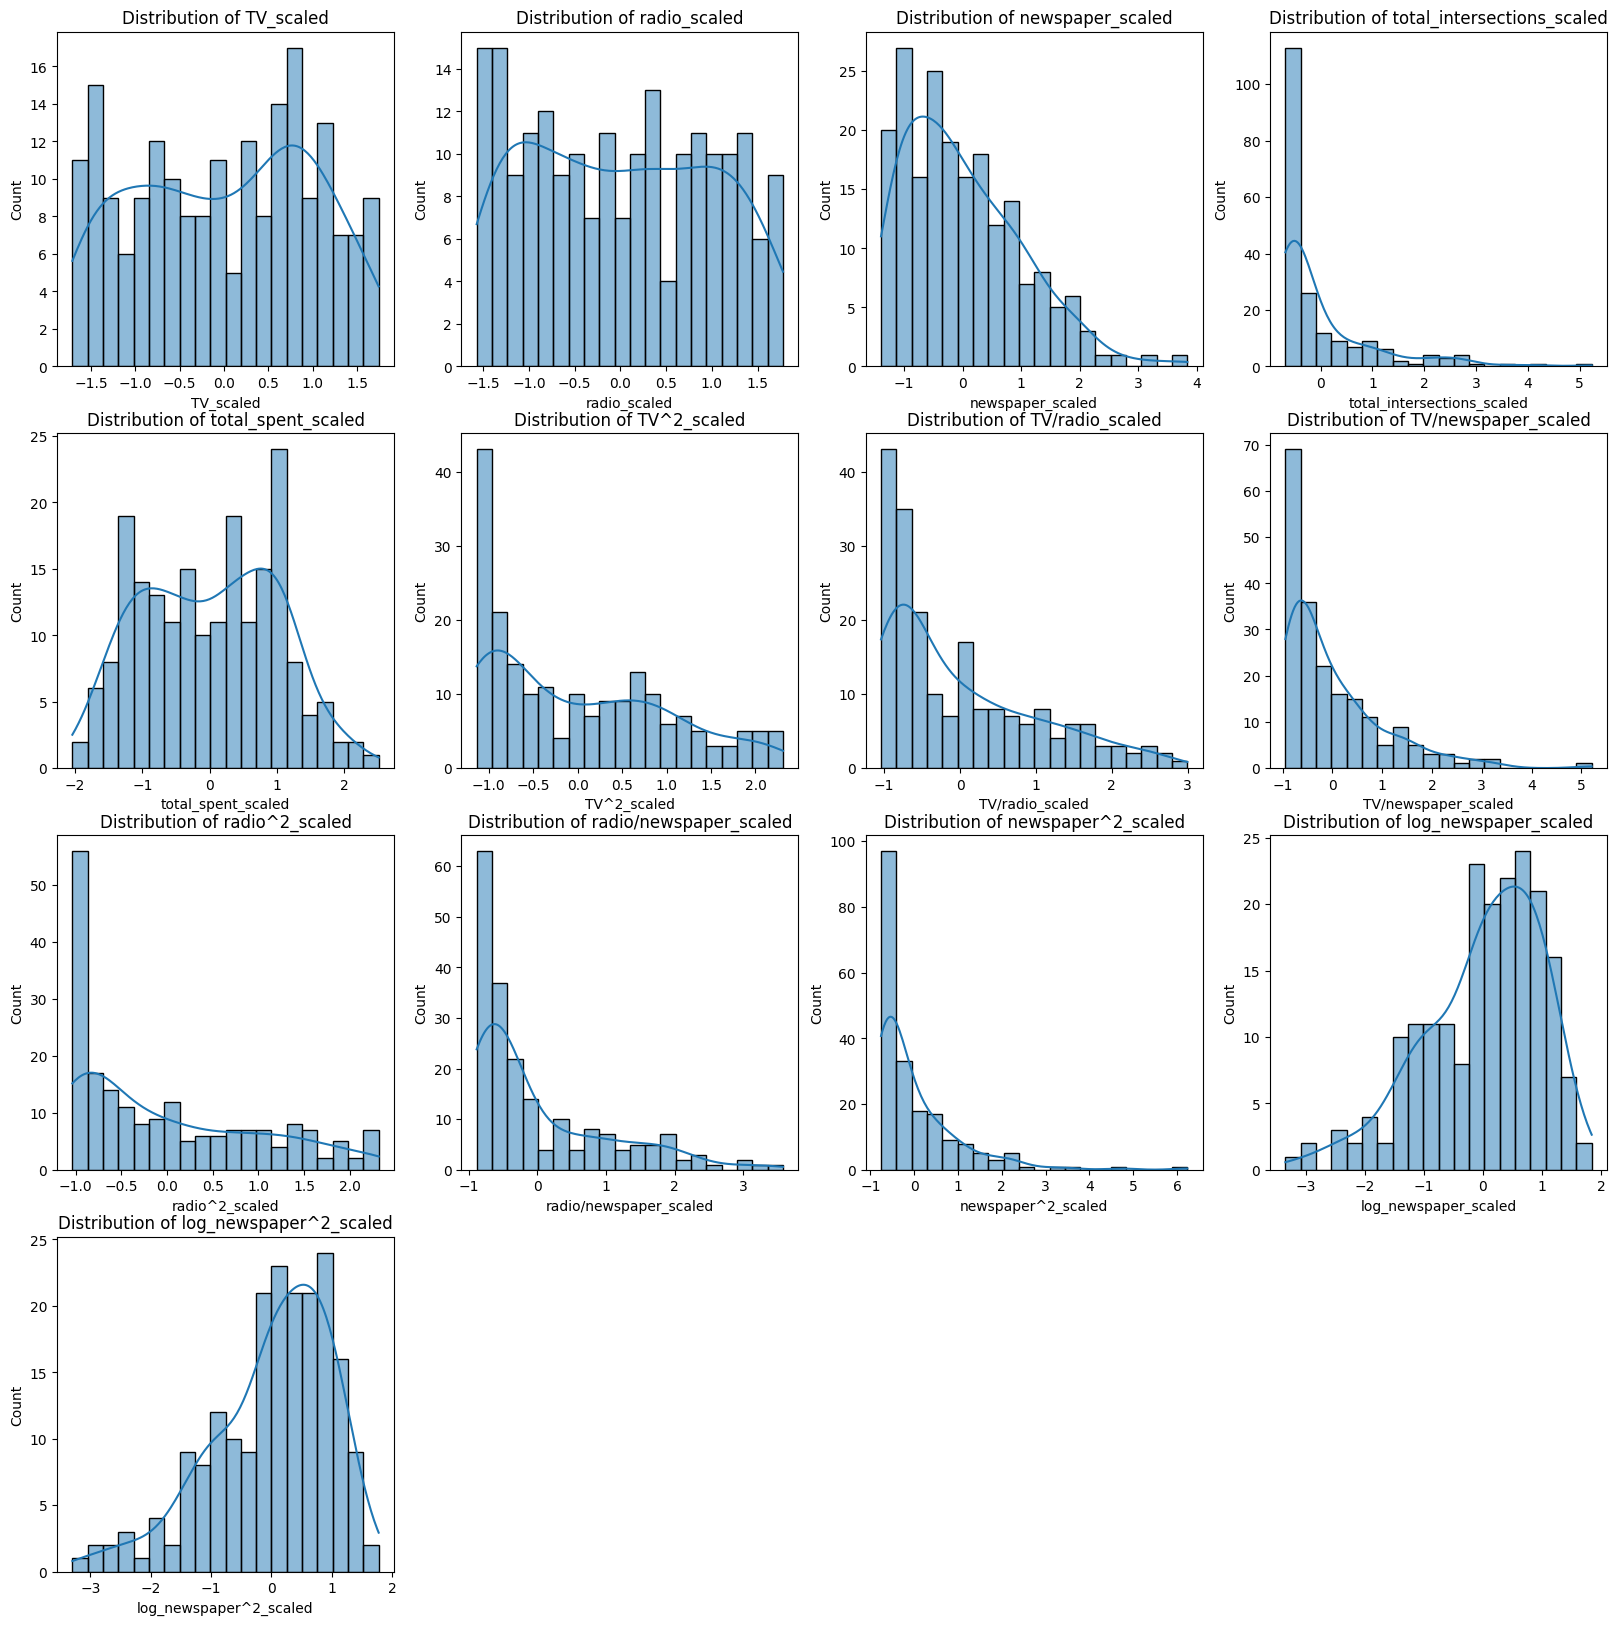

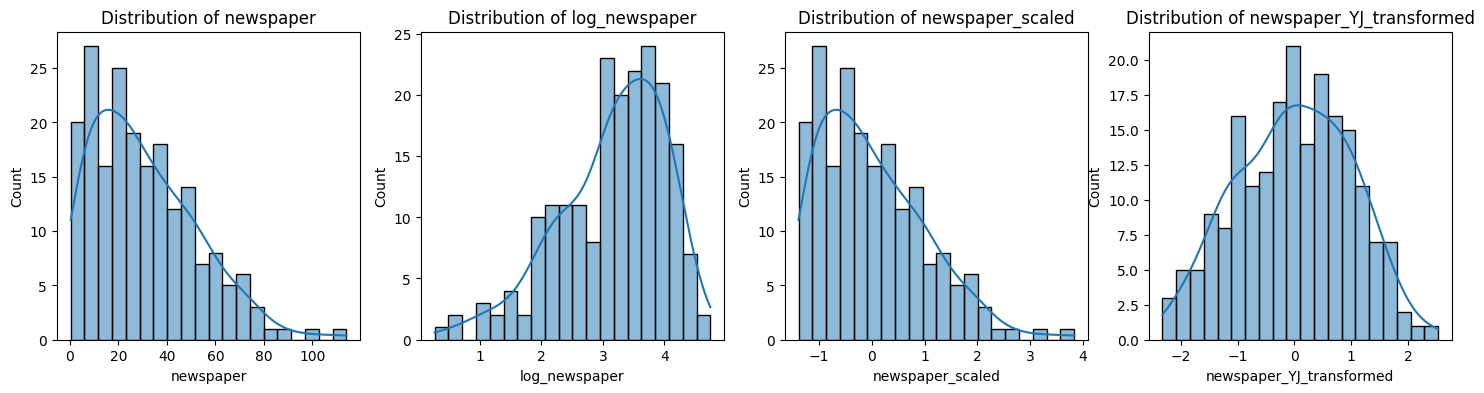

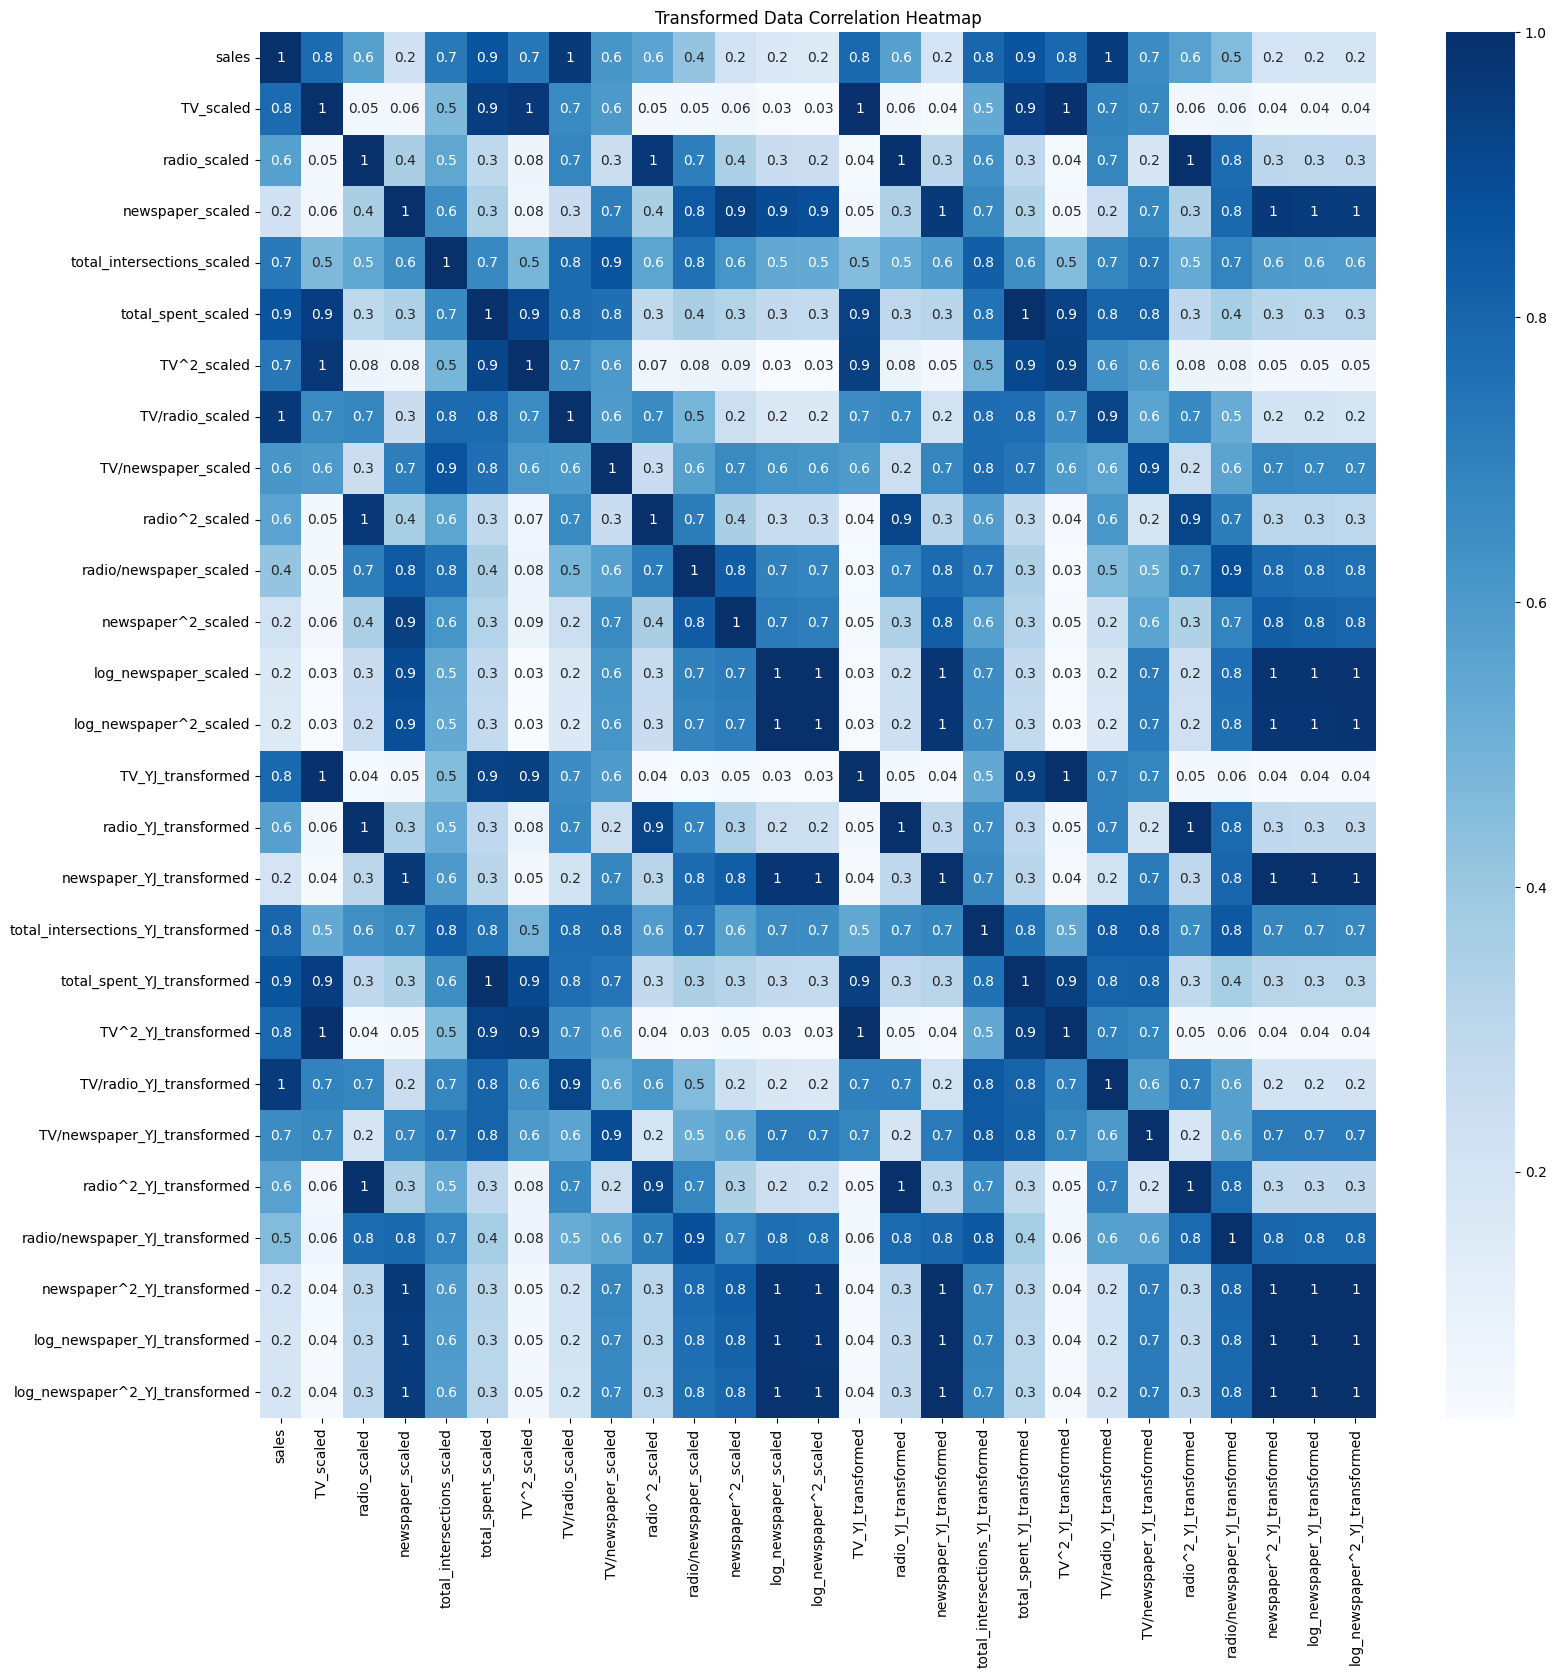

Корреляция признаков с продажами (после feature transformation):
sales                                 1.000000
TV/radio_scaled                       0.963932
TV/radio_YJ_transformed               0.955343
total_spent_scaled                    0.867712
total_spent_YJ_transformed            0.866138
total_intersections_YJ_transformed    0.795278
TV^2_YJ_transformed                   0.788807
TV_YJ_transformed                     0.788695
TV_scaled                             0.782224
TV^2_scaled                           0.735582
total_intersections_scaled            0.728699
TV/newspaper_YJ_transformed           0.656981
TV/newspaper_scaled                   0.618533
radio_scaled                          0.576223
radio_YJ_transformed                  0.570964
radio^2_YJ_transformed                0.570045
radio^2_scaled                        0.561608
radio/newspaper_YJ_transformed        0.458456
radio/newspaper_scaled                0.415893
newspaper_scaled                      0.22

In [32]:
all_data_reg, transformed_data_reg = feature_transformation(reg_data, 'sales')

# Проверка распределения после преобразований (для признака newspaper)
plt.figure(figsize=(18, 4))
for i, column in enumerate(['newspaper', 'log_newspaper', 'newspaper_scaled', 'newspaper_YJ_transformed'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(all_data_reg[column], kde=True, bins=20)
    plt.title(f"Distribution of {column}")

# Проверка корреляций после преобразований
plt.figure(figsize=(18, 18))
corr_matrix(transformed_data_reg, 'pearson', 'Transformed Data Correlation Heatmap')
plt.show()
correlation_with_sales = transformed_data_reg.corr()['sales'].sort_values(ascending=False)
print("Корреляция признаков с продажами (после feature transformation):")
print(correlation_with_sales)

#### Преобразование признаков в датасете для классификации

Выполним аналогичные действия для датасета для задачи классификации:

In [33]:
features_to_log = ['age', 'trestbps', 'chol', 'thalach']  # Логарифмирование признаков
to_log(class_data, features_to_log)

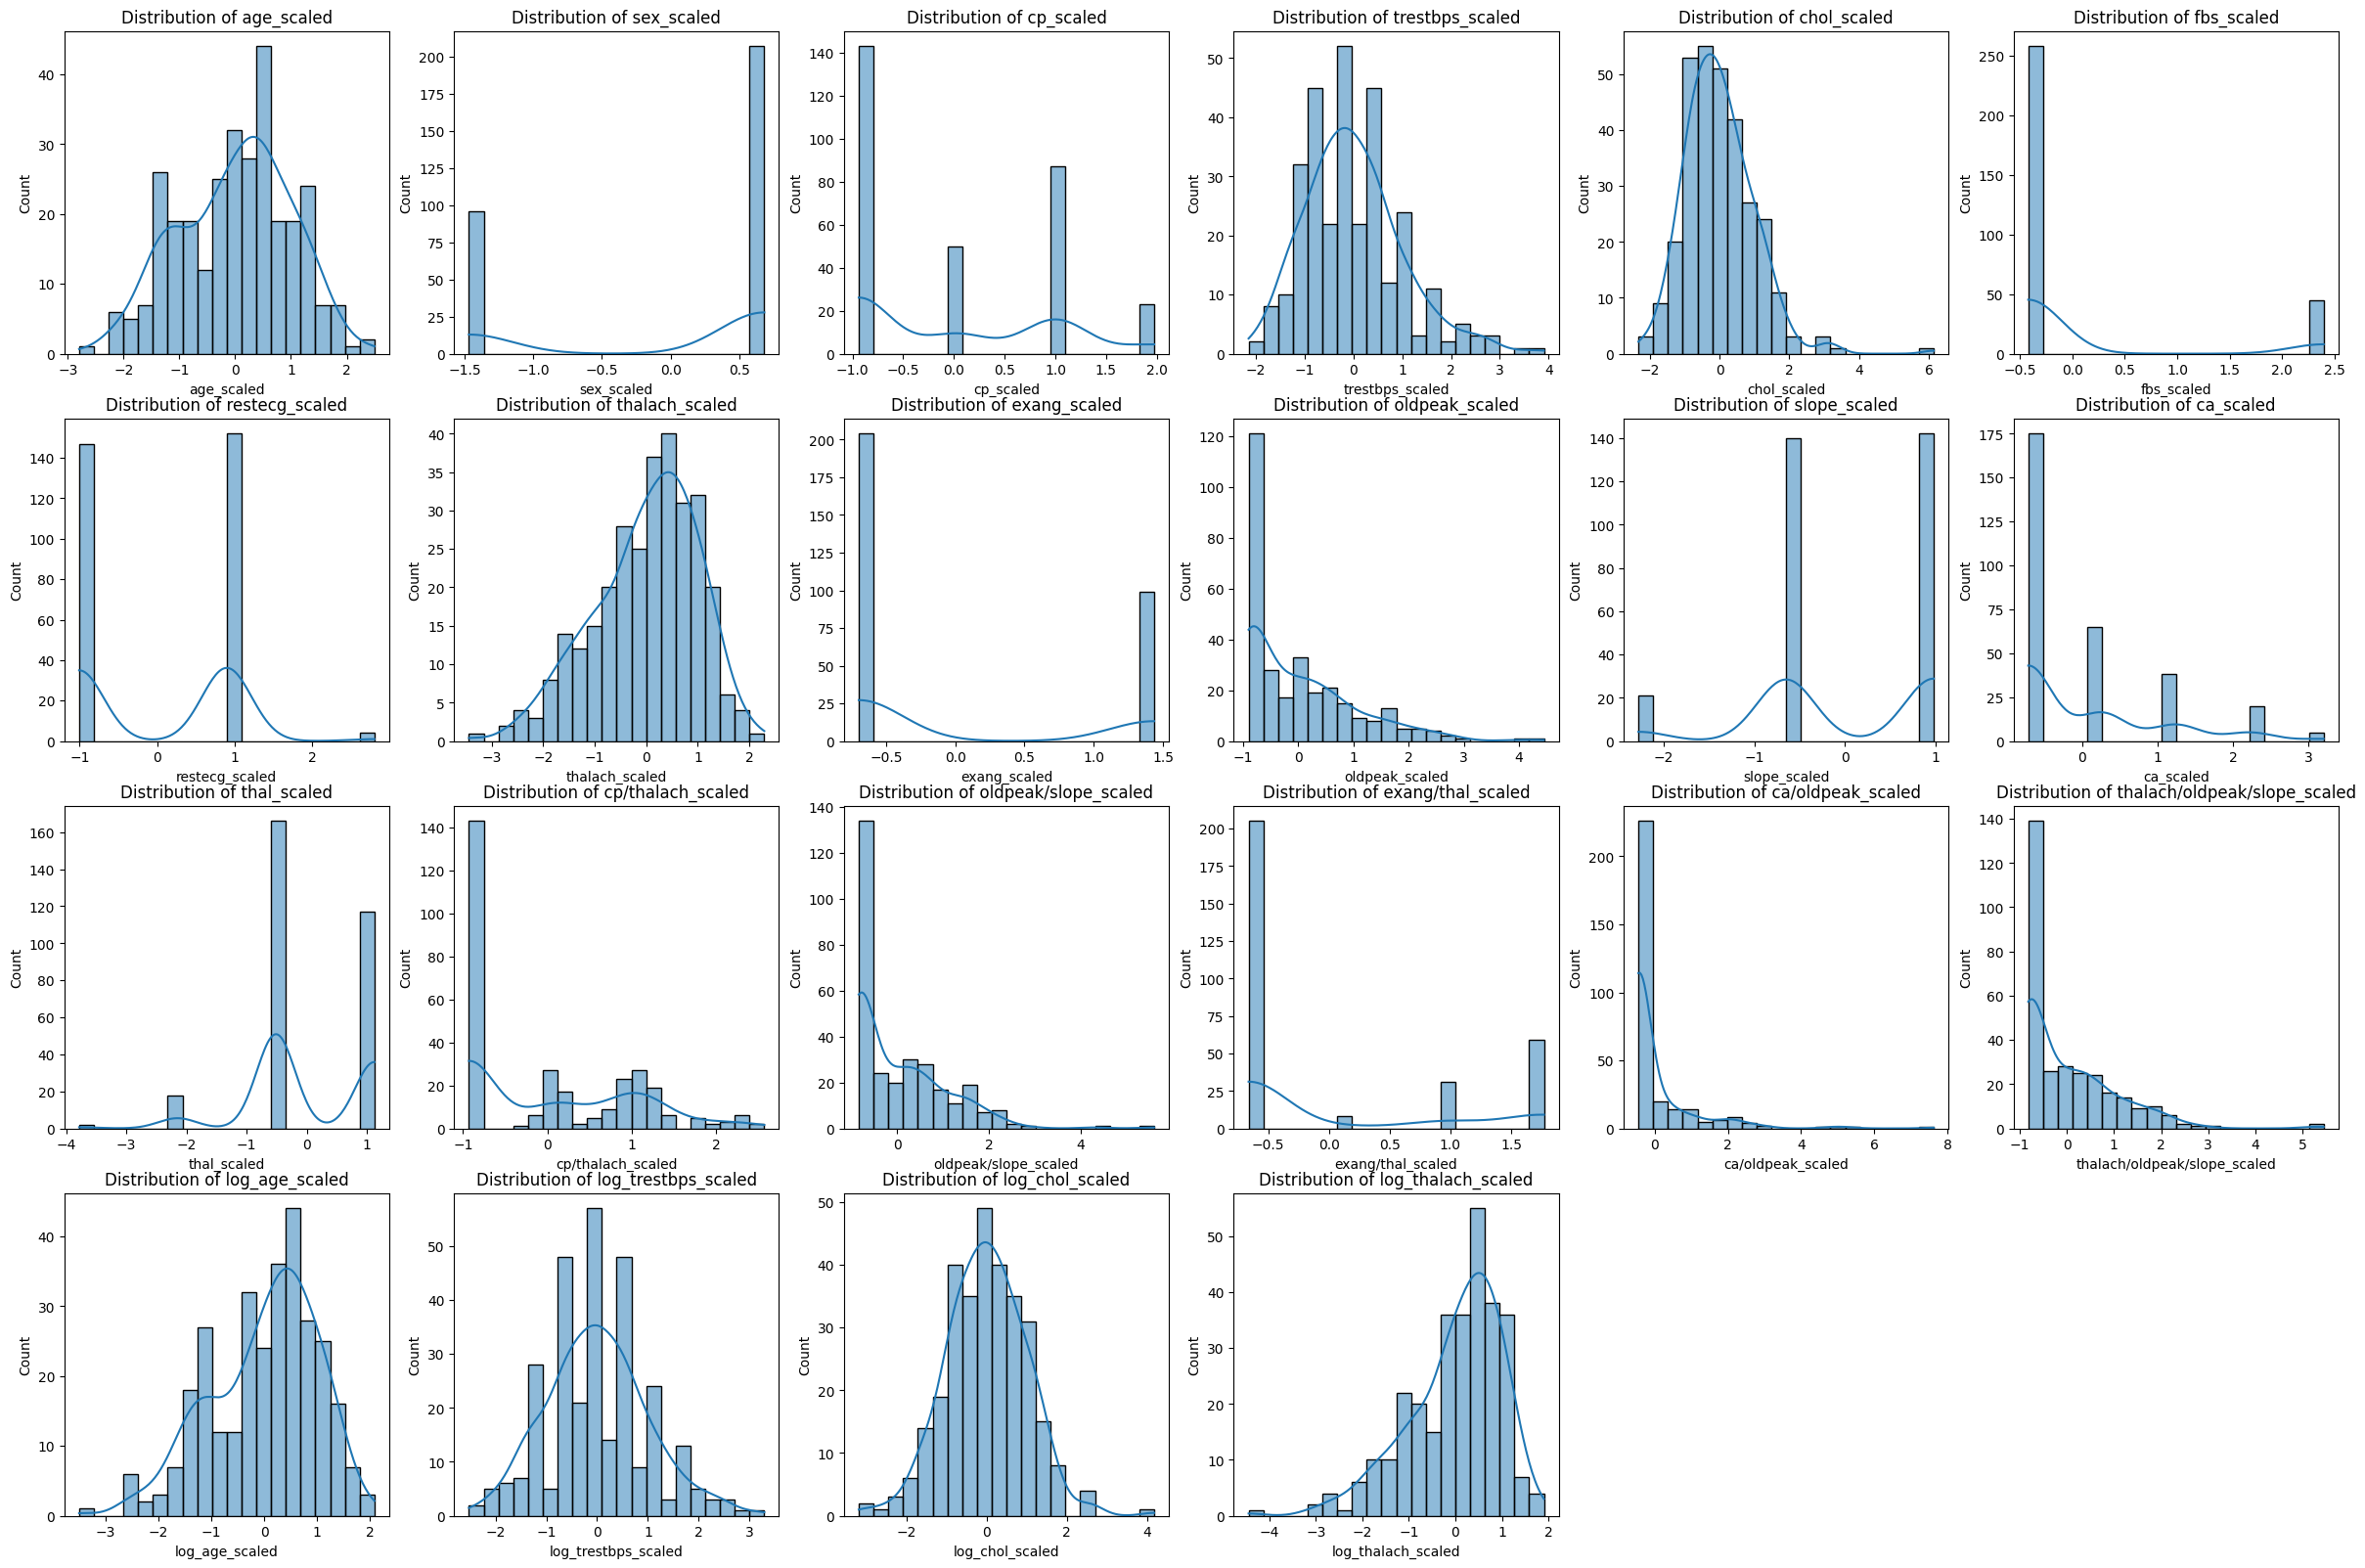

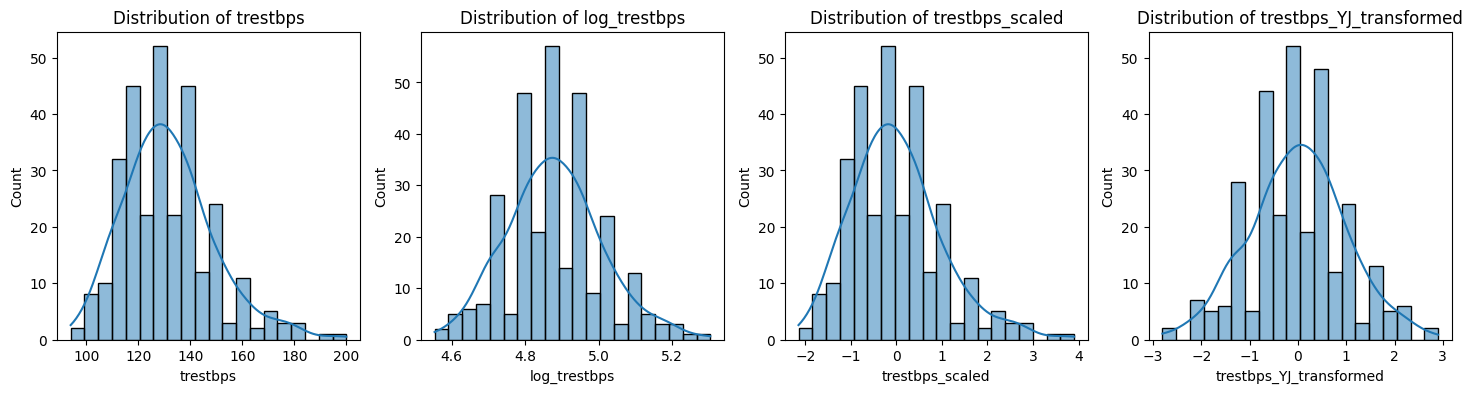

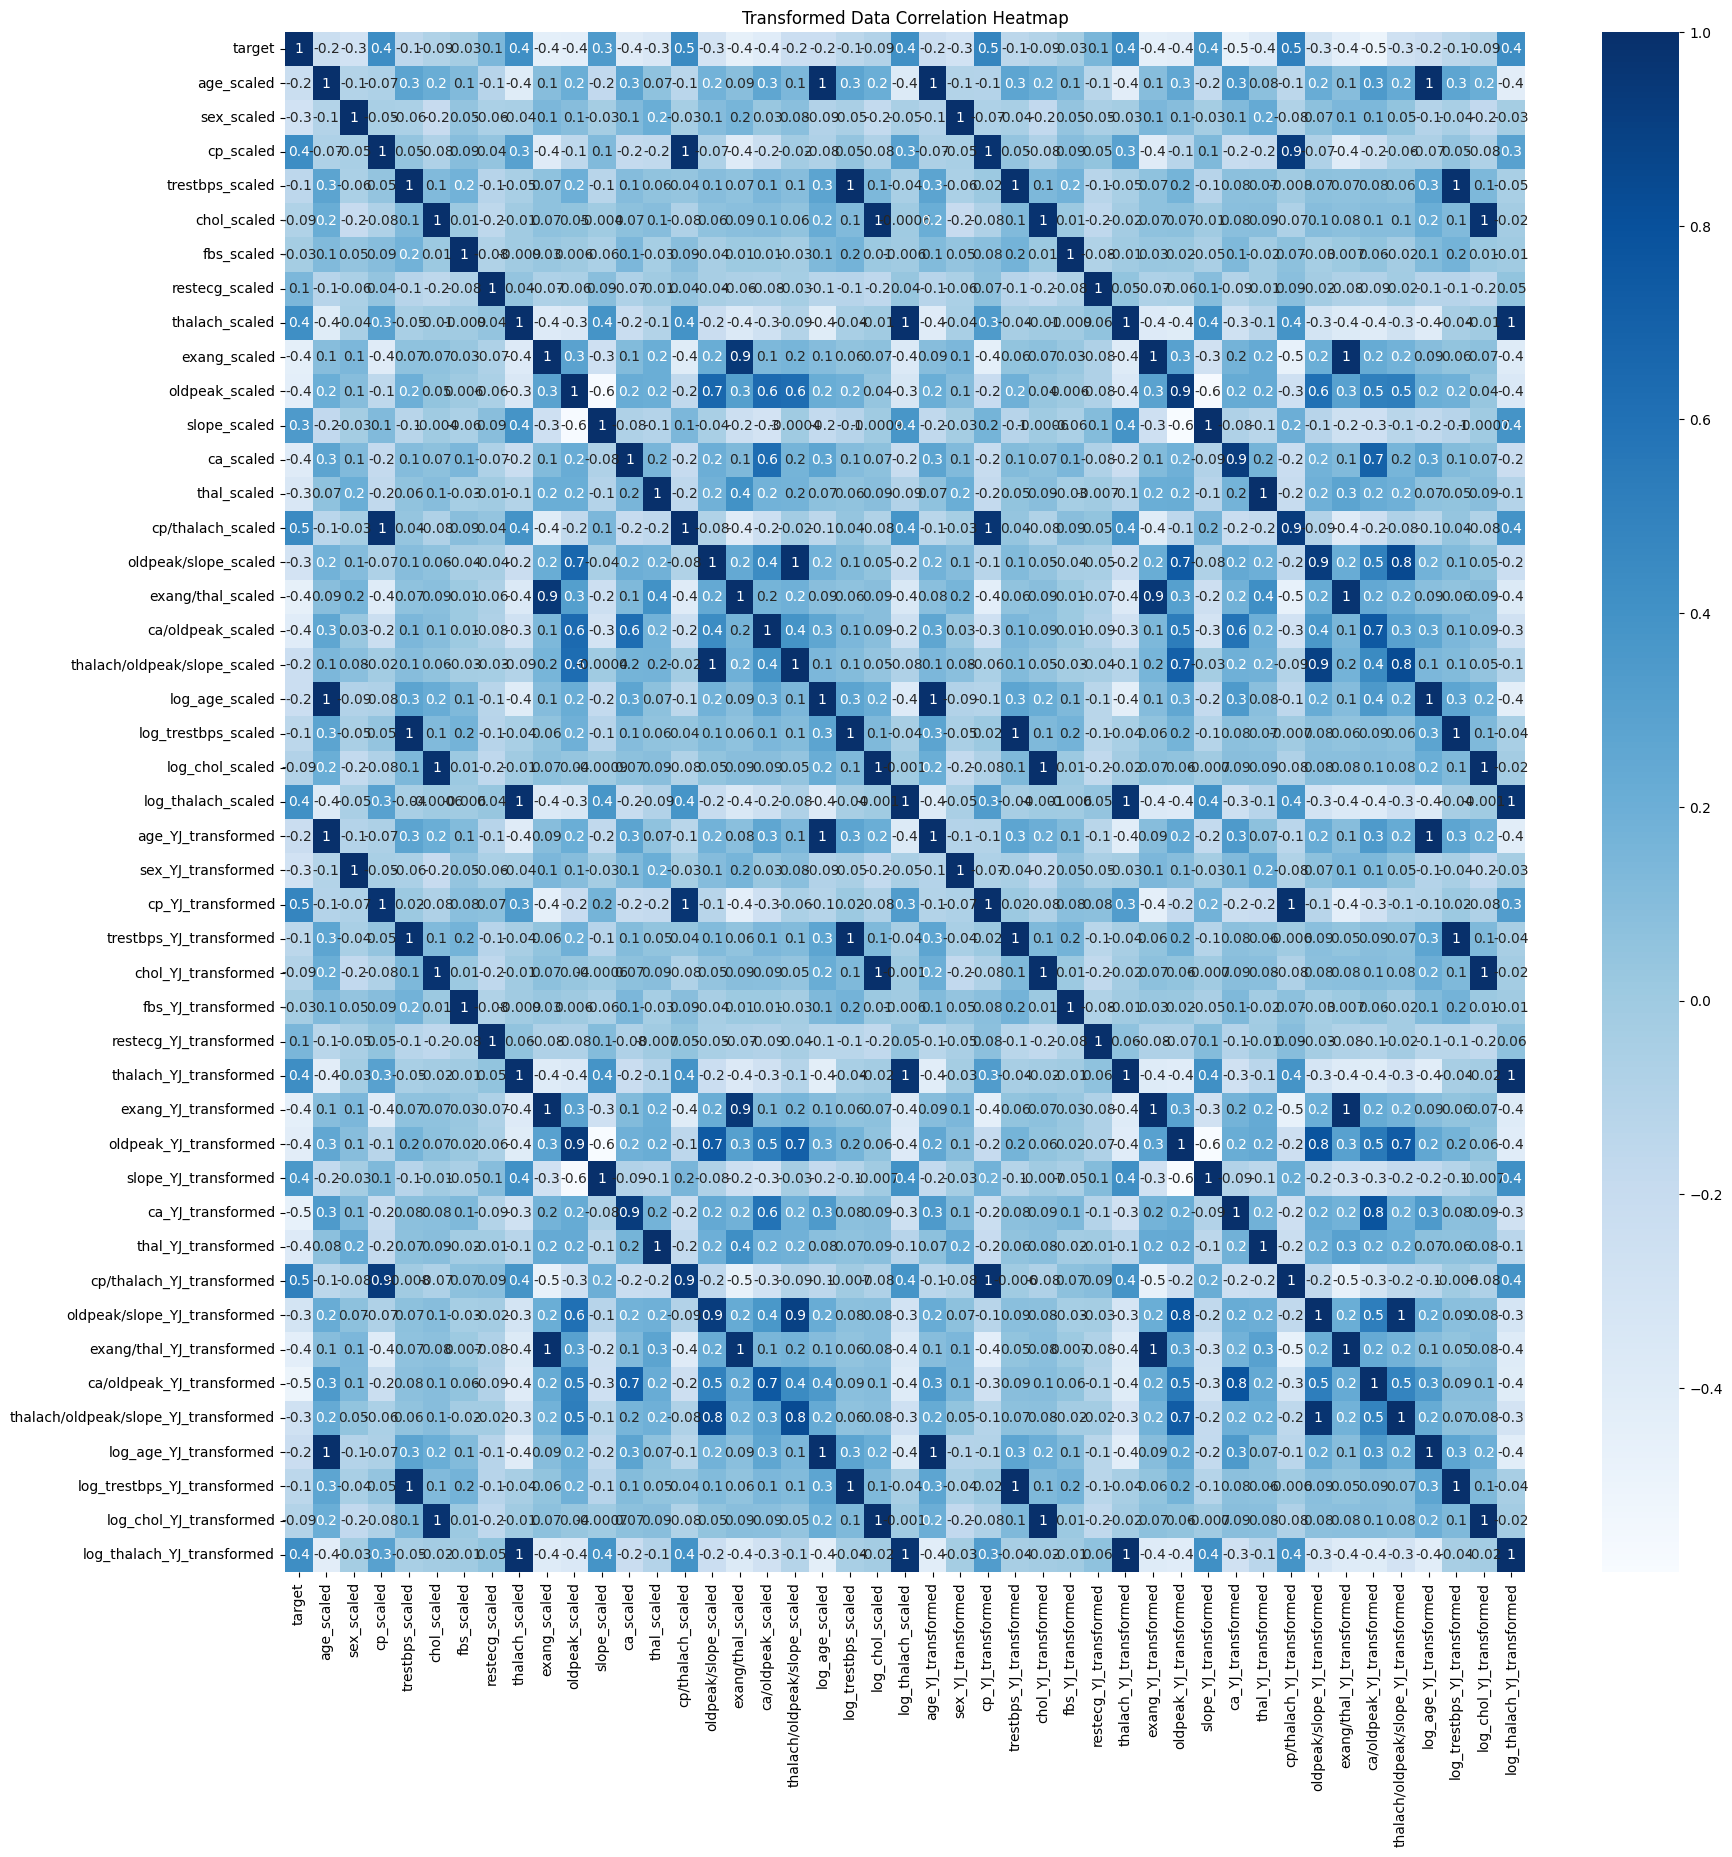

Корреляция признаков с целевой переменной target (после feature transformation):
target                                  1.000000
cp/thalach_YJ_transformed               0.513244
cp_YJ_transformed                       0.482151
cp/thalach_scaled                       0.453050
cp_scaled                               0.433798
log_thalach_YJ_transformed              0.424244
thalach_YJ_transformed                  0.424096
thalach_scaled                          0.421741
log_thalach_scaled                      0.413464
slope_YJ_transformed                    0.364309
slope_scaled                            0.345877
restecg_YJ_transformed                  0.147376
restecg_scaled                          0.137230
fbs_scaled                             -0.028046
fbs_YJ_transformed                     -0.028046
chol_scaled                            -0.085239
log_chol_scaled                        -0.092856
log_chol_YJ_transformed                -0.093068
chol_YJ_transformed                  

In [34]:
all_data_class, transformed_data_class = feature_transformation(class_data, 'target')

# Проверка распределения после преобразований (для признака trestbps)
plt.figure(figsize=(18, 4))
for i, column in enumerate(['trestbps', 'log_trestbps', 'trestbps_scaled', 'trestbps_YJ_transformed'], 1):
    plt.subplot(1, 4, i)
    sns.histplot(all_data_class[column], kde=True, bins=20)
    plt.title(f"Distribution of {column}")

# Проверка корреляций после преобразований
plt.figure(figsize=(20, 20))
corr_matrix(transformed_data_class, 'pearson', 'Transformed Data Correlation Heatmap')
plt.show()
correlation_with_target = transformed_data_class.corr()['target'].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной target (после feature transformation):")
print(correlation_with_target)

### Feature Selection

Зададим функцию для выполнения feature selection:

In [35]:
# Функция для feature seletion и выделения X и y для дальнейшего отбора
def feature_selection(data, threshold, target):
    correlation_matrix = data.corr()

    # Сохраняем признаки с высокой корреляцией с целевой переменной
    selected_features = correlation_matrix[target][abs(correlation_matrix[target]) > threshold].index.tolist()
    print(f"Features with correlation > {threshold} with sales: {selected_features}")

    # Удаляем признаки с низким значением корреляции
    selected_features.remove(target)
    filtered_data = data[selected_features + [target]]

    # 3. Выявление выбросов (используем значение Z-score для формирования рейтинга)
    z_score = s.zscore(filtered_data[selected_features])
    outliers = (abs(z_score) > 3).any(axis=1)  # Объекты с выбросами
    print(f"Количество выбросов: {outliers.sum()}")

    # Удаление выбросов
    cleaned_data = filtered_data[~outliers]

    X = cleaned_data.drop(columns=[target])
    y = cleaned_data[target]

    return cleaned_data, X, y

#### Отбор признаков в датасете для регрессии

Выполним отбор признаков по уровню корреляции и удаление тех признаков, которые не являются необходимыми для выполнения дальнейшей работы с датасетом:

Features with correlation > 0.4 with sales: ['sales', 'TV_scaled', 'radio_scaled', 'total_intersections_scaled', 'total_spent_scaled', 'TV^2_scaled', 'TV/radio_scaled', 'TV/newspaper_scaled', 'radio^2_scaled', 'radio/newspaper_scaled', 'TV_YJ_transformed', 'radio_YJ_transformed', 'total_intersections_YJ_transformed', 'total_spent_YJ_transformed', 'TV^2_YJ_transformed', 'TV/radio_YJ_transformed', 'TV/newspaper_YJ_transformed', 'radio^2_YJ_transformed', 'radio/newspaper_YJ_transformed']
Количество выбросов: 7
Feature Importance (SelectKBest):
                               Feature        Score
5                      TV/radio_scaled  2371.557666
14             TV/radio_YJ_transformed  1971.349360
3                   total_spent_scaled   576.556087
12          total_spent_YJ_transformed   571.343875
11  total_intersections_YJ_transformed   321.514064
13                 TV^2_YJ_transformed   301.816882
9                    TV_YJ_transformed   301.441198
0                            TV_scale

/var/folders/jc/zct8_l1d5bv8v8kgkd7kkvrc0000gn/T/ipykernel_88829/3787336768.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='Score', y='Feature', palette='Blues_r')


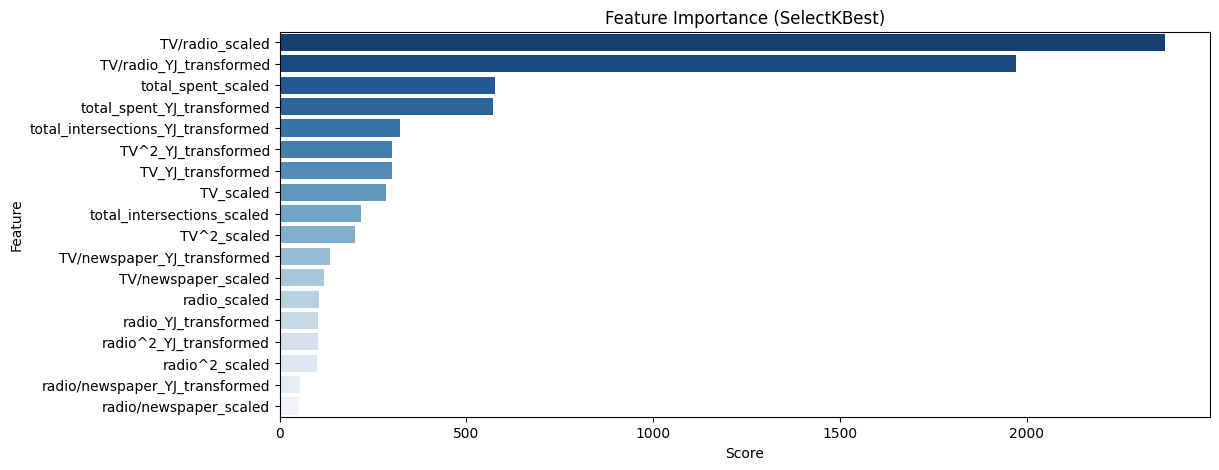

Feature Importance (Random Forest):
                               Feature  Importance
14             TV/radio_YJ_transformed    0.464214
5                      TV/radio_scaled    0.417797
12          total_spent_YJ_transformed    0.037353
3                   total_spent_scaled    0.033652
13                 TV^2_YJ_transformed    0.014926
9                    TV_YJ_transformed    0.010487
4                          TV^2_scaled    0.009369
0                            TV_scaled    0.006872
15         TV/newspaper_YJ_transformed    0.000967
11  total_intersections_YJ_transformed    0.000920
6                  TV/newspaper_scaled    0.000679
10                radio_YJ_transformed    0.000580
7                       radio^2_scaled    0.000414
16              radio^2_YJ_transformed    0.000394
1                         radio_scaled    0.000380
8               radio/newspaper_scaled    0.000366
17      radio/newspaper_YJ_transformed    0.000339
2           total_intersections_scaled    0.00

/var/folders/jc/zct8_l1d5bv8v8kgkd7kkvrc0000gn/T/ipykernel_88829/3787336768.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances, x='Importance', y='Feature', palette='Blues_r')


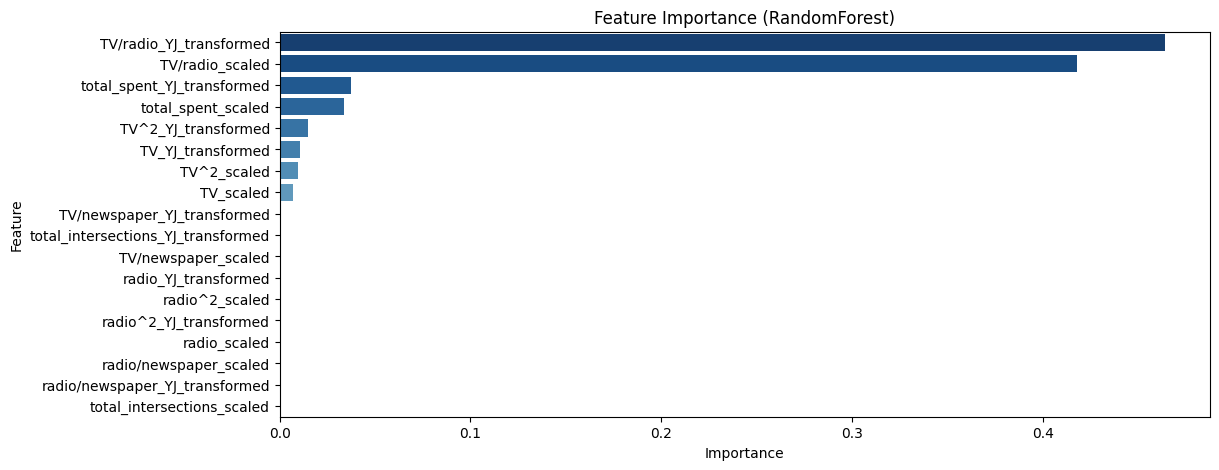

In [36]:
updated_reg_data, X_reg, y_reg = feature_selection(transformed_data_reg, 0.4, 'sales')

# Отбор признаков с помощью SelectKBest
k_best = SelectKBest(score_func=f_regression, k='all')  # Используем F-регрессию
k_best.fit(X_reg, y_reg)

# Выводим оценки важности признаков
feature_scores = pd.DataFrame({
    'Feature': X_reg.columns,
    'Score': k_best.scores_
}).sort_values(by='Score', ascending=False)
print("Feature Importance (SelectKBest):")
print(feature_scores)

# Визуализация важности признаков после отбора с SelectKBest
plt.figure(figsize=(12, 5))
sns.barplot(data=feature_scores, x='Score', y='Feature', palette='Blues_r')
plt.title("Feature Importance (SelectKBest)")
plt.show()

# Отбор признаков с помощью RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_reg, y_reg)

# Оценка важности признаков после отбора с RandomForest
rf_importances = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (Random Forest):")
print(rf_importances)

# Визуализация важности признаков после отбора с RandomForest
plt.figure(figsize=(12, 5))
sns.barplot(data=rf_importances, x='Importance', y='Feature', palette='Blues_r')
plt.title("Feature Importance (RandomForest)")
plt.show()

#### Отбор признаков в датасете для классификации

Выполним аналогичные преобразования для датасета классификации:

Features with correlation > 0.14 with sales: ['target', 'age_scaled', 'sex_scaled', 'cp_scaled', 'trestbps_scaled', 'thalach_scaled', 'exang_scaled', 'oldpeak_scaled', 'slope_scaled', 'ca_scaled', 'thal_scaled', 'cp/thalach_scaled', 'oldpeak/slope_scaled', 'exang/thal_scaled', 'ca/oldpeak_scaled', 'thalach/oldpeak/slope_scaled', 'log_age_scaled', 'log_trestbps_scaled', 'log_thalach_scaled', 'age_YJ_transformed', 'sex_YJ_transformed', 'cp_YJ_transformed', 'trestbps_YJ_transformed', 'restecg_YJ_transformed', 'thalach_YJ_transformed', 'exang_YJ_transformed', 'oldpeak_YJ_transformed', 'slope_YJ_transformed', 'ca_YJ_transformed', 'thal_YJ_transformed', 'cp/thalach_YJ_transformed', 'oldpeak/slope_YJ_transformed', 'exang/thal_YJ_transformed', 'ca/oldpeak_YJ_transformed', 'thalach/oldpeak/slope_YJ_transformed', 'log_age_YJ_transformed', 'log_trestbps_YJ_transformed', 'log_thalach_YJ_transformed']
Количество выбросов: 20
Feature Importance (SelectKBest):
                                 Feature

/var/folders/jc/zct8_l1d5bv8v8kgkd7kkvrc0000gn/T/ipykernel_88829/309694457.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='Score', y='Feature', palette='Blues_r')


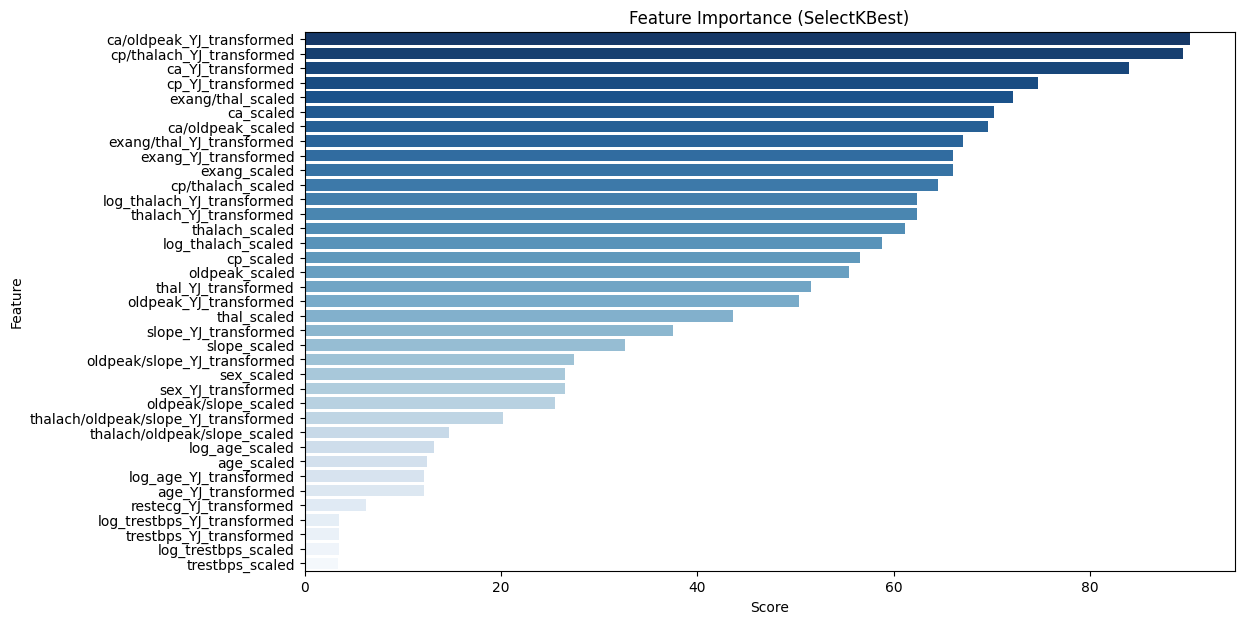

Feature Importance (Random Forest):
                                 Feature  Importance
10                     cp/thalach_scaled    0.105340
29             cp/thalach_YJ_transformed    0.095958
13                     ca/oldpeak_scaled    0.067294
32             ca/oldpeak_YJ_transformed    0.062565
9                            thal_scaled    0.053871
28                   thal_YJ_transformed    0.051178
27                     ca_YJ_transformed    0.048560
8                              ca_scaled    0.040609
6                         oldpeak_scaled    0.035830
25                oldpeak_YJ_transformed    0.026912
23                thalach_YJ_transformed    0.021752
0                             age_scaled    0.021190
36            log_thalach_YJ_transformed    0.020449
4                         thalach_scaled    0.020396
34                log_age_YJ_transformed    0.020390
17                    log_thalach_scaled    0.020106
18                    age_YJ_transformed    0.020053
26        

/var/folders/jc/zct8_l1d5bv8v8kgkd7kkvrc0000gn/T/ipykernel_88829/309694457.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances, x='Importance', y='Feature', palette='Blues_r')


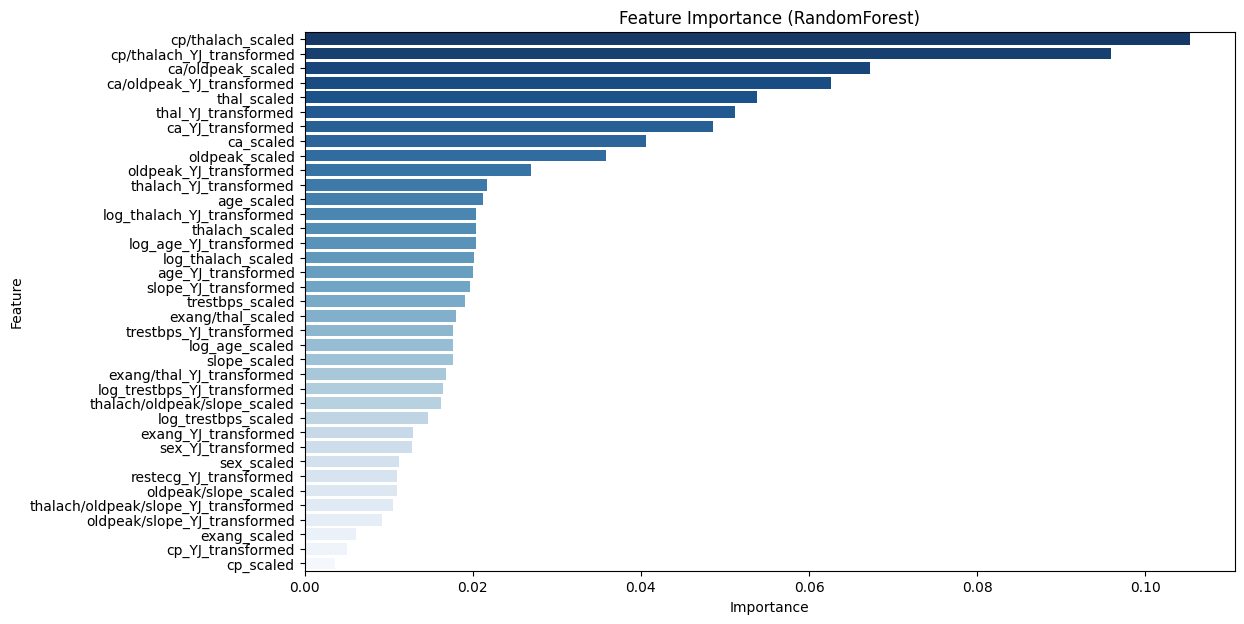

In [37]:
updated_class_data, X_class, y_class = feature_selection(transformed_data_class, 0.14, 'target')

# Отбор признаков с помощью SelectKBest
k_best = SelectKBest(score_func=f_regression, k='all')  # Используем F-регрессию
k_best.fit(X_class, y_class)

# Выводим оценки важности признаков
feature_scores = pd.DataFrame({
    'Feature': X_class.columns,
    'Score': k_best.scores_
}).sort_values(by='Score', ascending=False)
print("Feature Importance (SelectKBest):")
print(feature_scores)

# Визуализация важности признаков после отбора с SelectKBest
plt.figure(figsize=(12, 7))
sns.barplot(data=feature_scores, x='Score', y='Feature', palette='Blues_r')
plt.title("Feature Importance (SelectKBest)")
plt.show()

# Отбор признаков с помощью RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_class, y_class)

# Оценка важности признаков после отбора с RandomForest
rf_importances = pd.DataFrame({
    'Feature': X_class.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (Random Forest):")
print(rf_importances)

# Визуализация важности признаков после отбора с RandomForest
plt.figure(figsize=(12, 7))
sns.barplot(data=rf_importances, x='Importance', y='Feature', palette='Blues_r')
plt.title("Feature Importance (RandomForest)")
plt.show()

## **Выводы**

### Выводы из анализа данных в датасете для регрессии

Выведем итоговый датасет с преобразованными признаками:

In [38]:
updated_reg_data

TV_scaled  radio_scaled  total_intersections_scaled  total_spent_scaled  \
0     0.969852      0.981522                    2.596654            1.468851   
1    -1.197376      1.082808                   -0.251005           -0.775834   
2    -1.516155      1.528463                   -0.382561           -0.738099   
3     0.052050      1.217855                    1.312491            0.543808   
4     0.394182     -0.841614                   -0.059563            0.529792   
..         ...           ...                         ...                 ...   
194   0.031031      0.832971                   -0.506347           -0.103075   
195  -1.270941     -1.321031                   -0.669827           -1.565032   
196  -0.617035     -1.240003                   -0.660090           -1.009790   
197   0.349810     -0.942899                   -0.623086           -0.087982   
199   0.993206     -0.990165                   -0.585895            0.523323   

     TV^2_scaled  TV/radio_scaled  TV/newspaper_scaled  radio^2_scaled  \
0       0.940748         1.553389             2.330912        0.910534   
1      -1.057797        -0.519478            -0.533326        1.068102   
2      -1.123849        -0.805658            -0.701070        1.834242   
3      -0.235412         0.825289             0.877761        1.287731   
4       0.146386        -0.458687             1.226832       -0.877288   
..           ...              ...                  ...             ...   
194    -0.256672         0.548577            -0.761533        0.690524   
195    -1.078228        -0.998998            -0.837902       -1.017553   
196    -0.787483        -0.903471            -0.789356       -1.003493   
197     0.093070        -0.550128            -0.713247       -0.918366   
199     0.976997        -0.445735            -0.530790       -0.935438   

     radio/newspaper_scaled  TV_YJ_transformed  radio_YJ_transformed  \
0                  1.914570           0.948674              0.962247   
1                  1.013068          -1.191314              1.040179   
2                  2.518661          -1.647757              1.370710   
3                  1.701084           0.141020              1.142387   
4                 -0.207396           0.452715             -0.748651   
..                      ...                ...                   ...   
194               -0.653288           0.121376              0.845832   
195               -0.827040          -1.287908             -1.431436   
196               -0.839194          -0.520949             -1.297017   
197               -0.817996           0.413091             -0.875492   
199               -0.801641           0.968161             -0.937083   

     total_intersections_YJ_transformed  total_spent_YJ_transformed  \
0                              1.772062                    1.401348   
1                              0.289415                   -0.735239   
2                              0.070170                   -0.694548   
3                              1.363401                    0.575267   
4                              0.523789                    0.562286   
..                                  ...                         ...   
194                           -0.229324                   -0.042100   
195                           -1.432687                   -1.665173   
196                           -1.198884                   -0.993652   
197                           -0.772387                   -0.027222   
199                           -0.539851                    0.556290   

     TV^2_YJ_transformed  TV/radio_YJ_transformed  \
0               0.947699                 1.328881   
1              -1.190026                -0.200907   
2              -1.651777                -0.731909   
3               0.143474                 0.953953   
4               0.454091                -0.117112   
..                   ...                      ...   
194             0.123886                 0.783917   
195          

Сохраним файл с признаками со значением корреляции с объемом продаж больше заданного (`threshold = 0.4`) как обновленный датасет:

In [39]:
updated_reg_data.to_csv(
    'advertising_updated.csv',
    index=False,
    encoding='utf-8'
    )

### Выводы из анализа данных в датасете для классификации

Выполним аналогичные действия со вторым датасетом:

In [40]:
updated_class_data

age_scaled  sex_scaled  cp_scaled  trestbps_scaled  thalach_scaled  \
0      0.952197    0.681005   1.973123         0.763956        0.015443   
1     -1.915313    0.681005   1.002577        -0.092738        1.633471   
2     -1.474158   -1.468418   0.032031        -0.092738        0.977514   
3      0.180175    0.681005   0.032031        -0.663867        1.239897   
4      0.290464   -1.468418  -0.938515        -0.663867        0.583939   
..          ...         ...        ...              ...             ...   
298    0.290464   -1.468418  -0.938515         0.478391       -1.165281   
299   -1.033002    0.681005   1.973123        -1.234996       -0.771706   
300    1.503641    0.681005  -0.938515         0.706843       -0.378132   
301    0.290464    0.681005  -0.938515        -0.092738       -1.515125   
302    0.290464   -1.468418   0.032031        -0.092738        1.064975   

     exang_scaled  oldpeak_scaled  slope_scaled  ca_scaled  thal_scaled  ...  \
0       -0.696631        1.087338     -2.274579  -0.714429    -2.148873  ...   
1       -0.696631        2.122573     -2.274579  -0.714429    -0.512922  ...   
2       -0.696631        0.310912      0.976352  -0.714429    -0.512922  ...   
3       -0.696631       -0.206705      0.976352  -0.714429    -0.512922  ...   
4        1.435481       -0.379244      0.976352  -0.714429    -0.512922  ...   
..            ...             ...           ...        ...          ...  ...   
298      1.435481       -0.724323     -0.649113  -0.714429     1.123029  ...   
299     -0.696631        0.138373     -0.649113  -0.714429     1.123029  ...   
300     -0.696631        2.036303     -0.649113   1.244593     1.123029  ...   
301      1.435481        0.138373     -0.649113   0.265082     1.123029  ...   
302     -0.696631       -0.896862     -0.649113   0.265082    -0.512922  ...   

     thal_YJ_transformed  cp/thalach_YJ_transformed  \
0              -1.946718                   1.147413   
1              -0.583232                   1.072613   
2              -0.583232                   0.765144   
3              -0.583232                   0.778489   
4              -0.583232                  -1.051102   
..                   ...                        ...   
298             1.176072                  -1.051102   
299             1.176072                   1.095660   
300             1.176072                  -1.051102   
301             1.176072                  -1.051102   
302            -0.583232                   0.769641   

     oldpeak/slope_YJ_transformed  exang/thal_YJ_transformed  \
0                       -1.069676                  -0.689478   
1                       -1.069676                  -0.689478   
2                        1.336456                  -0.689478   
3                        0.833820                  -0.689478   
4                        0.573965                   1.393998   
..                            ...                        ...   
298                     -0.618479                   1.521267   
299                      0.573965                  -0.689478   
300                      1.502221                  -0.689478   
301                      0.573965                   1.521267   
302                     -1.069676                  -0.689478   

     ca/oldpeak_YJ_transformed  thalach/oldpeak/slope_YJ_transformed  \
0                    -0.657580                             -1.181036   
1                    -0.657580                             -1.181036   
2                    -0.657580                              1.237773   
3                    -0.657580                              0.962279   
4                    -0.657580                              0.775146   
..                         ...                                   ...   
298                  -0.657580                             -0.118286   
299                  -0.657580                              0.673588   
300                   1.785865                              1.235

In [41]:
updated_class_data.to_csv(
    'heart_updated.csv',
    index=False,
    encoding='utf-8'
    )